In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
# import pyedflib
import os
import glob
# import tensorflow as tf
from tqdm import tqdm
from lxml import etree

In [2]:
BASE_DB_PATH = '/mnt/dat/databases/shhs/polysomnography'
TO_PATH = '/mnt/dat/prepped/apnea_sp02_pr'

SAMPLING_RATE = 1.0 

SEGMENT_LENGTH = 150 # input to model
SINGLE_ANNOT = 30 # annotate for every 30s

# consider only below channels
SELECTED_CHANNELS = ['SaO2', 'H.R.', 'PR', 'OX stat', 'OX STAT']

In [3]:
shhs1_edfs = glob.glob(os.path.join(BASE_DB_PATH, 'edfs/shhs1/*.edf'))
shhs2_edfs = glob.glob(os.path.join(BASE_DB_PATH, 'edfs/shhs2/*.edf'))
shhs1_edfs = sorted(shhs1_edfs)[:10] # only get samples
shhs2_edfs = sorted(shhs2_edfs)[:10]

len(shhs1_edfs), len(shhs2_edfs)

(10, 10)

In [4]:
shhs1_xmls = glob.glob(os.path.join(BASE_DB_PATH, 'annotations-events-nsrr/shhs1/*.xml'))
shhs2_xmls = glob.glob(os.path.join(BASE_DB_PATH, 'annotations-events-nsrr/shhs2/*.xml'))
shhs1_xmls = sorted(shhs1_xmls)[:10]
shhs2_xmls = sorted(shhs2_xmls)[:10]

len(shhs1_xmls), len(shhs2_xmls)

(10, 10)

# Examine a sample record

In [5]:
def get_edf(path, channels):
    return mne.io.read_raw_edf(path, include=channels, 
                               verbose=False, preload=False)

In [6]:
edf = get_edf(shhs1_edfs[1], SELECTED_CHANNELS)
edf

<RawEDF | shhs1-200002.edf, 3 x 32370 (32369.0 s), ~9 kB, data not loaded>

32370


<Axes: >

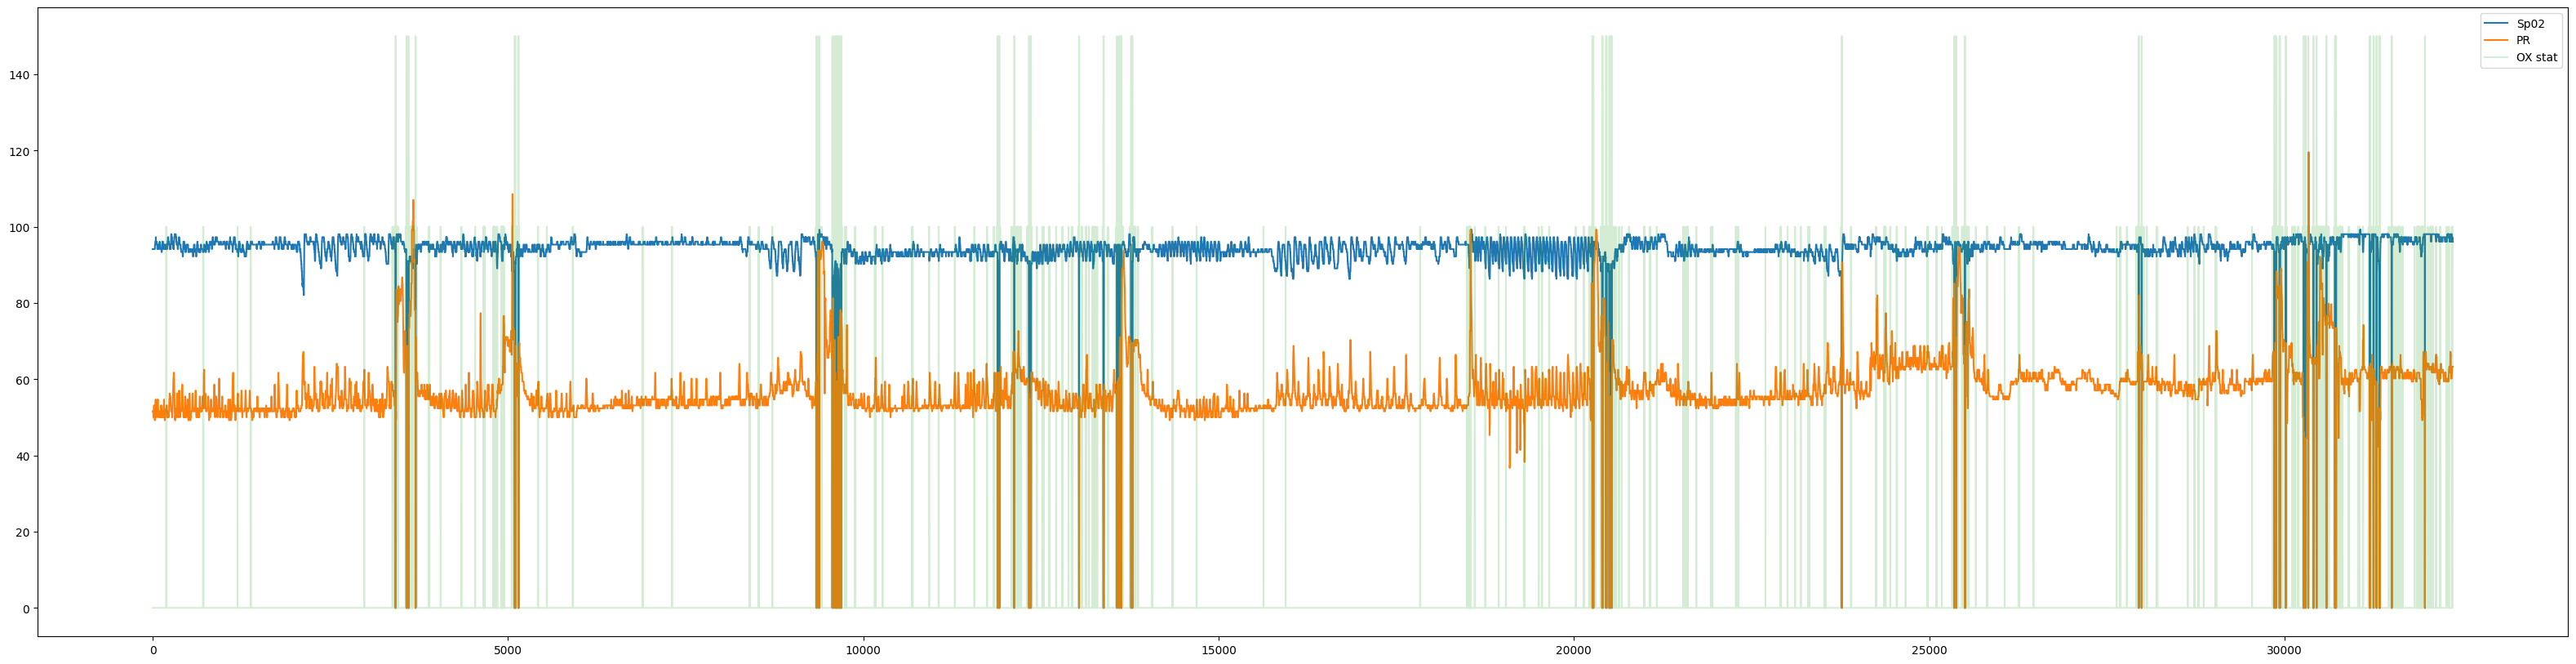

In [7]:
dataa1 = edf.get_data()
print(len(dataa1[1]))
plt.figure(figsize=(40, 10))
sns.lineplot(dataa1[0], label='Sp02')
sns.lineplot(dataa1[1], label='PR')
sns.lineplot(dataa1[2] * 50, label='OX stat', alpha=0.2)

# Read annotation

In [8]:
def create_annotation(xml_path, start_date, selected_channels):
    # Use lxml's fast parser
    parser = etree.XMLParser(remove_blank_text=True, collect_ids=False)
    
    # Use xpath for direct access to elements
    tree = etree.parse(xml_path, parser)
    
    onset = []
    duration = []
    description = []
    ch_names = []
    
    for event in tree.xpath(".//ScoredEvent"):
        event_name = event.find('EventConcept').text
        ch_name = event.find('SignalLocation')
        if ch_name is None:
            ch_name = []
        elif ch_name.text in selected_channels:
            ch_name = [ch_name.text]
        else:
            ch_name = [] # or ignore by continue


        start_time = float(event.find('Start').text)
        sduration = float(event.find('Duration').text)
        
        onset.append(start_time)
        duration.append(sduration)
        description.append(event_name)
        ch_names.append(ch_name)
    return mne.Annotations(onset=onset, duration=duration, description=description, ch_names=ch_names, orig_time=start_date)

In [9]:
anott = create_annotation(shhs1_xmls[1], edf.info['meas_date'], SELECTED_CHANNELS)

edf = edf.set_annotations(anott)

anott.to_data_frame()

onset  duration                          description  \
0   1985-01-01 00:00:00     270.0                      Stage 2 sleep|2   
1   1985-01-01 00:00:00   32370.0                 Recording Start Time   
2   1985-01-01 00:00:13      17.0                    Hypopnea|Hypopnea   
3   1985-01-01 00:00:34      28.0                    Hypopnea|Hypopnea   
4   1985-01-01 00:00:43      17.0  SpO2 desaturation|SpO2 desaturation   
..                  ...       ...                                  ...   
541 1985-01-01 08:40:49       6.0          SpO2 artifact|SpO2 artifact   
542 1985-01-01 08:41:32       5.0          SpO2 artifact|SpO2 artifact   
543 1985-01-01 08:42:12      12.0          SpO2 artifact|SpO2 artifact   
544 1985-01-01 08:45:05       6.0          SpO2 artifact|SpO2 artifact   
545 1985-01-01 08:52:53       4.0          SpO2 artifact|SpO2 artifact   

    ch_names  
0         ()  
1         ()  
2         ()  
3         ()  
4    (SaO2,)  
..       ...  
541  (SaO2,)  
542  (SaO2,)  
543  (SaO2,)  
544  (SaO2,)  
545  (SaO2,)  

[546 rows x 4 columns]

# Read raw data

In [10]:
all_record = {}

for path in shhs1_xmls + shhs2_xmls:
    record = path[path.rfind("/") + 1:path.rfind("-nsrr.xml")]
    all_record[record] = [None, path]

for path in shhs1_edfs + shhs2_edfs:
    record = path[path.rfind("/") + 1:path.rfind(".edf")]
    all_record[record][0] = path

In [11]:
selected_records = {}
for k, v in tqdm(all_record.items()):
    if v[0] and v[1]:
        rawedf = get_edf(v[0], SELECTED_CHANNELS)
        if len(rawedf.ch_names) < 3: # no missing signals
            continue
        anno = create_annotation(v[1], rawedf.info['meas_date'], SELECTED_CHANNELS)
        rawedf.set_annotations(anno)
        selected_records[k] = rawedf
len(selected_records.keys())

  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_107451/2816200548.py:8: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  rawedf.set_annotations(anno)
/tmp/ipykernel_107451/2816200548.py:8: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  rawedf.set_annotations(anno)
/tmp/ipykernel_107451/2816200548.py:8: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  rawedf.set_annotations(anno)
/tmp/ipykernel_107451/2816200548.py:8: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  rawedf.set_annotations(anno)
100%|██████████| 20/20 [00:00<00:00, 149.46it/s]


20

# Preprocess

## Interpolate bad samples

In [12]:
def interpolate_bad_samples(raw: mne.io.Raw):
    # assume order: Sp02, PR, OX stat
    signal_picks = [0, 1] 
    ox_channel = [2]
    # Extract the data
    data = raw.get_data()
    ox_data = data[ox_channel, :].flatten()

    condition = ((ox_data > 0) | # bad OX stat
                 ((data[0, :] < 70) | (data[0, :] > 100)) | # SpO2 outside 70-100% range
                 ((data[1, :] < 40) | (data[1, :] > 150))) # PR outside 40-150 

    bad_indices = np.where(condition)[0] 
    
    for idx in signal_picks:
        signal_data = data[idx, :]

        good_indices = np.setdiff1d(np.arange(len(signal_data)), bad_indices)

        # Interpolate bad values
        signal_data[bad_indices] = np.interp(
            bad_indices, good_indices, signal_data[good_indices]
        )

        data[idx, :] = signal_data

    return data[signal_picks, :] # remove OX stat

(2, 32370)


<Axes: >

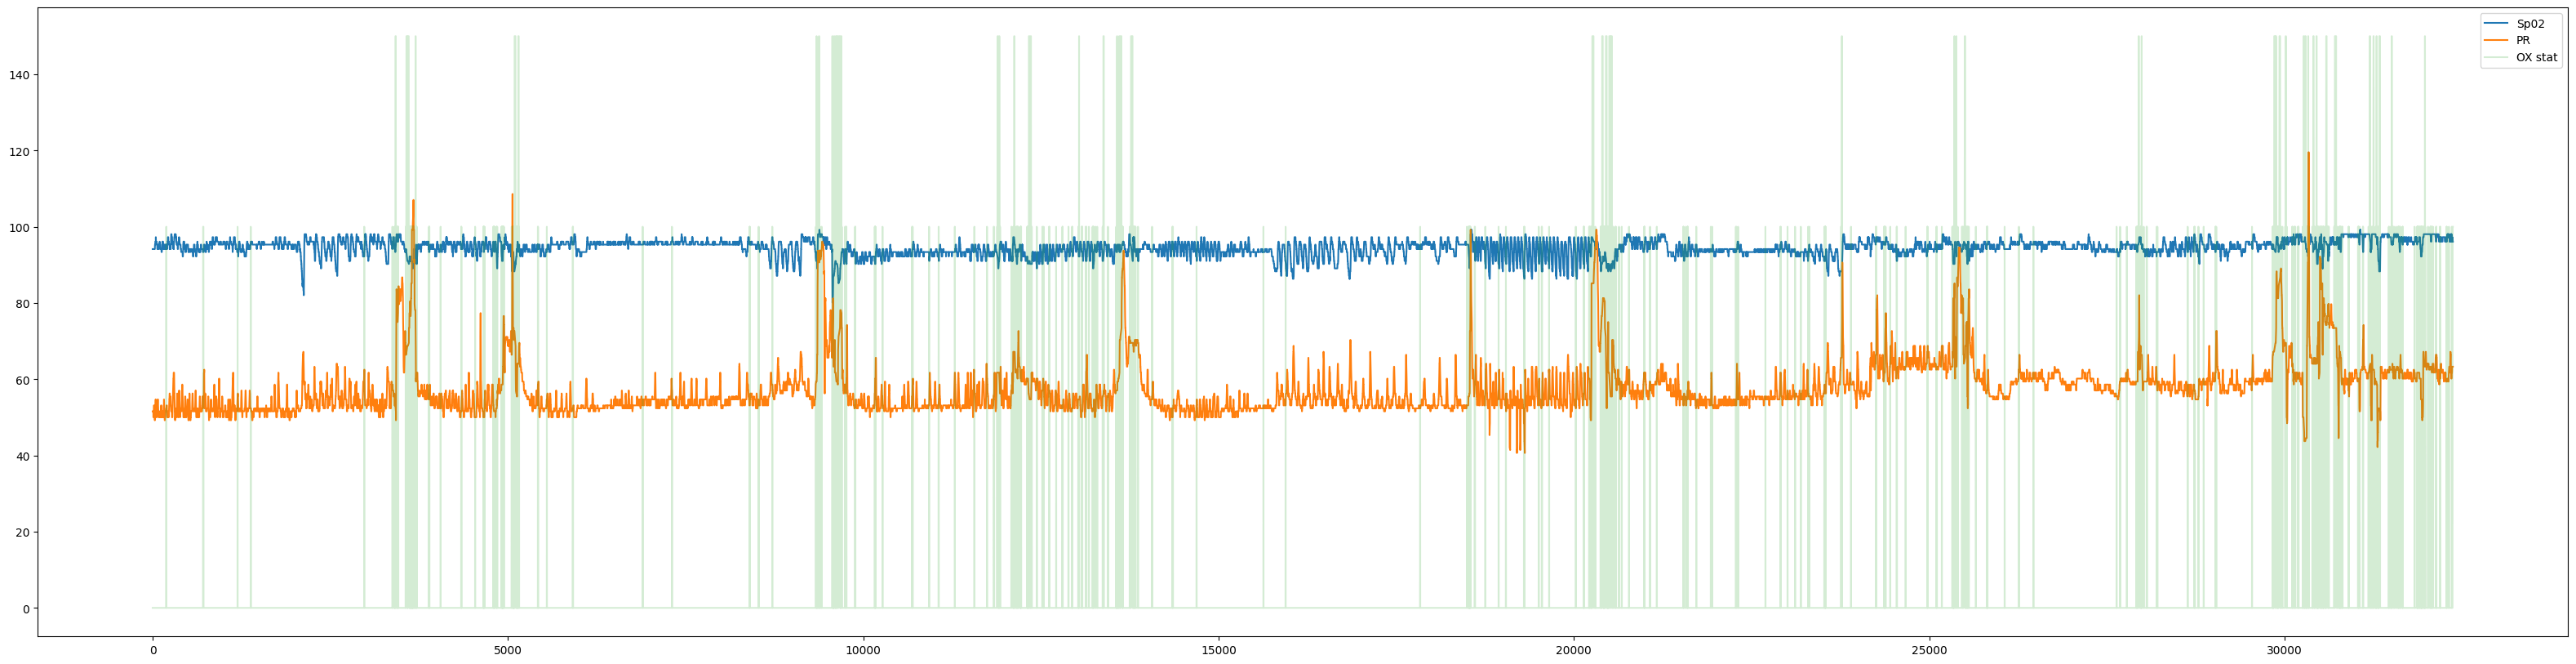

In [13]:
dataa = interpolate_bad_samples(edf)
print(dataa.shape)
plt.figure(figsize=(40, 10))

sns.lineplot(dataa[0], label='Sp02')
sns.lineplot(dataa[1], label='PR')
sns.lineplot(dataa1[2] * 50, label='OX stat', alpha=0.2)

## Standardize 

In [14]:
def standardize(sig: np.ndarray):
    return (sig - sig.mean()) / sig.std()

def sub_mean(sig: np.ndarray):
    return sig - sig.mean()

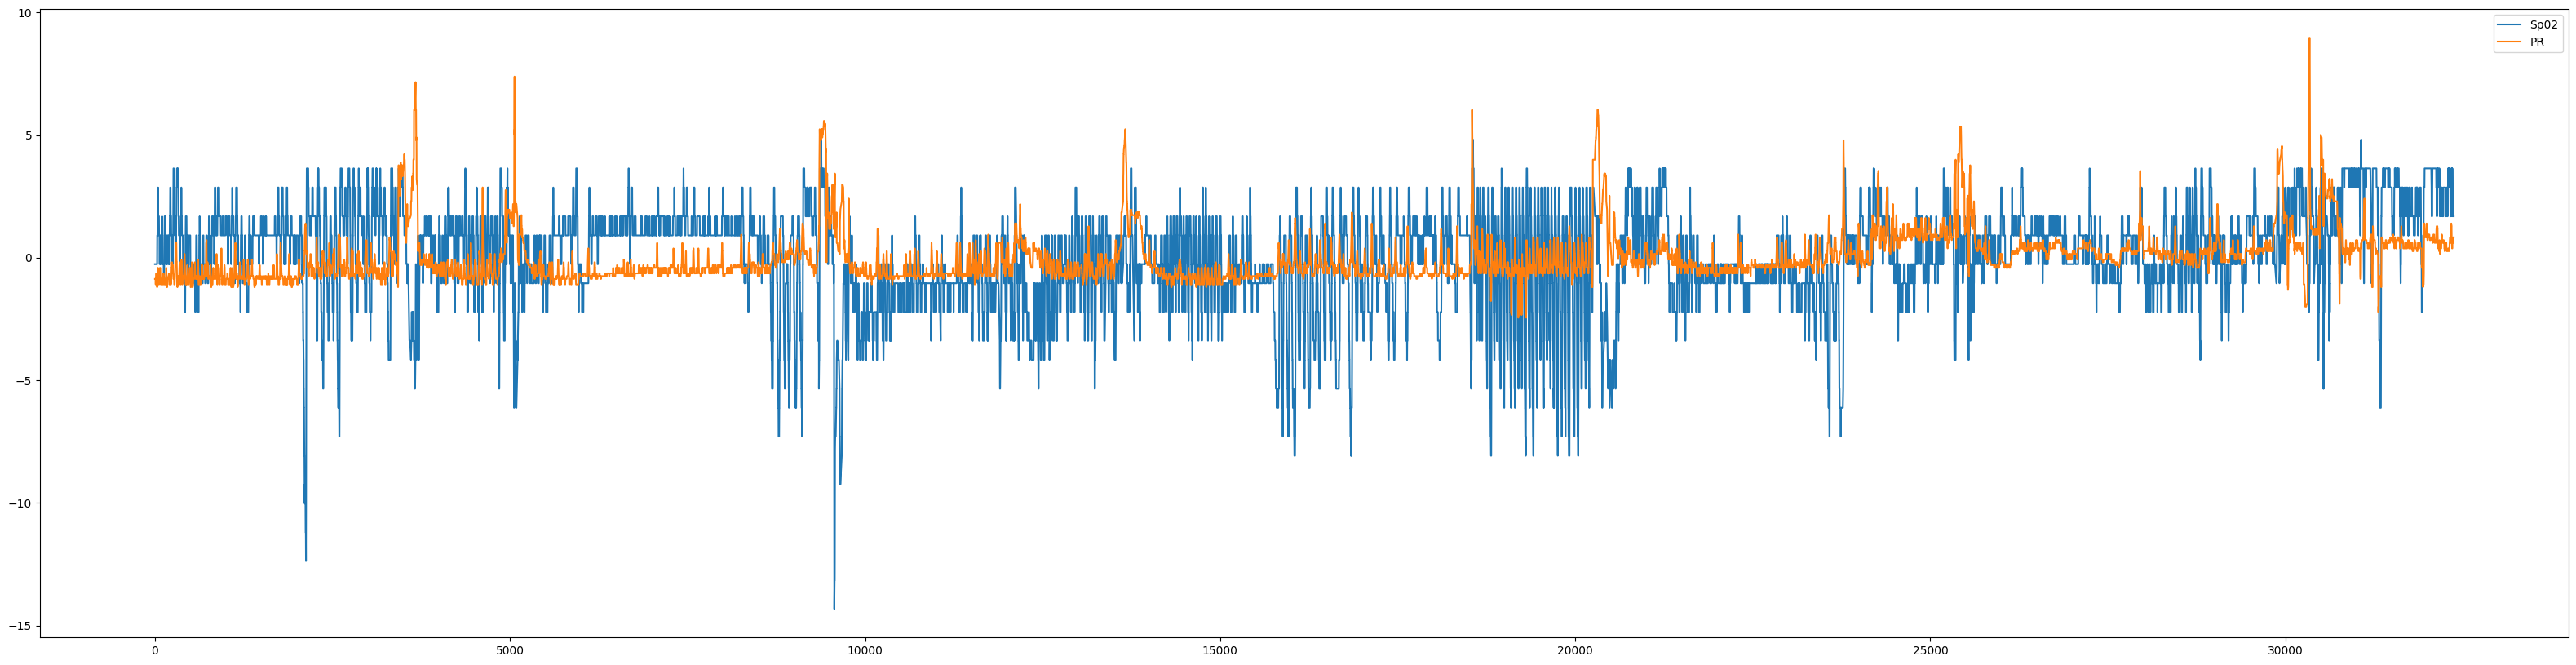

In [15]:
plt.figure(figsize=(40, 10))
sns.lineplot(sub_mean(dataa[0]), label='Sp02')
sns.lineplot(standardize(dataa[1]), label='PR')
plt.show()

## Desaturation

In [16]:
import numpy as np

def detect_desaturation_events(
    SpO2, 
    sampling_rate=1, 
    SpO2drop=2.9,  # A SpO2drop value of 2.9%
    window_baseline=60, # previous 60 s window
    event_duration=30, # if a drop ≥ SpO2drop from baseline (SpO2baseline ) occurs in the next 30 s
    max_event_duration=120 # event end: 3) 120 s
):
    """
    Detect desaturation events in SpO₂ data based on dynamic nadir calculation.
    
    Parameters:
    - SpO2: numpy array of SpO₂ values.
    - sampling_rate: Number of samples per second.
    - SpO2drop: Minimum drop from baseline to consider an event.
    - window_baseline: Baseline window size (in seconds).
    - event_duration: Duration to check for a drop (in seconds).
    - max_event_duration: Maximum allowed event duration (in seconds).
    
    Returns:
    - List of dictionaries with event start, end, and details.
    """
    baseline_samples = int(window_baseline * sampling_rate)
    event_samples = int(event_duration * sampling_rate)
    max_event_samples = int(max_event_duration * sampling_rate)
    
    onset = []
    offset = []
    
    slopes = np.diff(SpO2, prepend=SpO2[0])
    
    i = baseline_samples  # Start after the first baseline window
    while i < len(SpO2) - event_samples:
        # Calculate SpO2baseline (mean of previous baseline_samples)
        SpO2baseline = np.mean(SpO2[i - baseline_samples:i])
        
        # Check for drops in the next event_duration
        future_window = SpO2[i:i + event_samples]
        nadir_index = np.argmin(future_window)
        nadir_value = future_window[nadir_index]
        
        drop = SpO2baseline - future_window
        
        # slope
        cur_slopes = slopes[i:i + event_samples]
        cur_slopes = cur_slopes[cur_slopes.nonzero()[0]] # not consider plateau here
        sl_cond = cur_slopes <= -0.1 # with a slope ≥ 0.1% per second 
        
        if np.all(drop >= SpO2drop) and len(sl_cond) != 0 and np.all(sl_cond):
            event_start = i
            
            # Event end based on conditions
            for j in range(event_start + 1, min(len(SpO2), 
                                                event_start + max_event_samples)): # Condition 3: Max duration
                event_end = j
                if (
                    SpO2[j] >= SpO2baseline - 1  # Condition 1: Returns to baseline - 1
                    or SpO2[j] >= 1.5 * nadir_value  # Condition 2: Reaches 1.5 × nadir
                ):
                    break
            
            # Append the detected event
            onset.append(event_start)
            offset.append(event_end)
            
            i = event_end
            continue
        
        i += 1
    
    return onset, offset


# Example Usage
SpO2 = dataa[0]

on_pred, off_pred = detect_desaturation_events(SpO2)

In [17]:
def get_onset_offset(annot: mne.Annotations, label: str):
    adf = annot.to_data_frame()
    adf['lower_desc'] = adf['description'].str.lower()
    selected_df = adf[adf['lower_desc'].str.contains(label)].copy()
    start_time = adf[adf['description'].str.contains('Recording Start Time')]['onset'].iloc[0]

    startt = (selected_df["onset"] - start_time).dt.total_seconds().astype(int)
    off = (startt + selected_df["duration"]).astype(int)
    return startt, off

In [18]:
# annotated desaturation (should be ignored according to: https://ieeexplore.ieee.org/document/8322241/)
onsett, offsett = get_onset_offset(edf.annotations, 'desat')

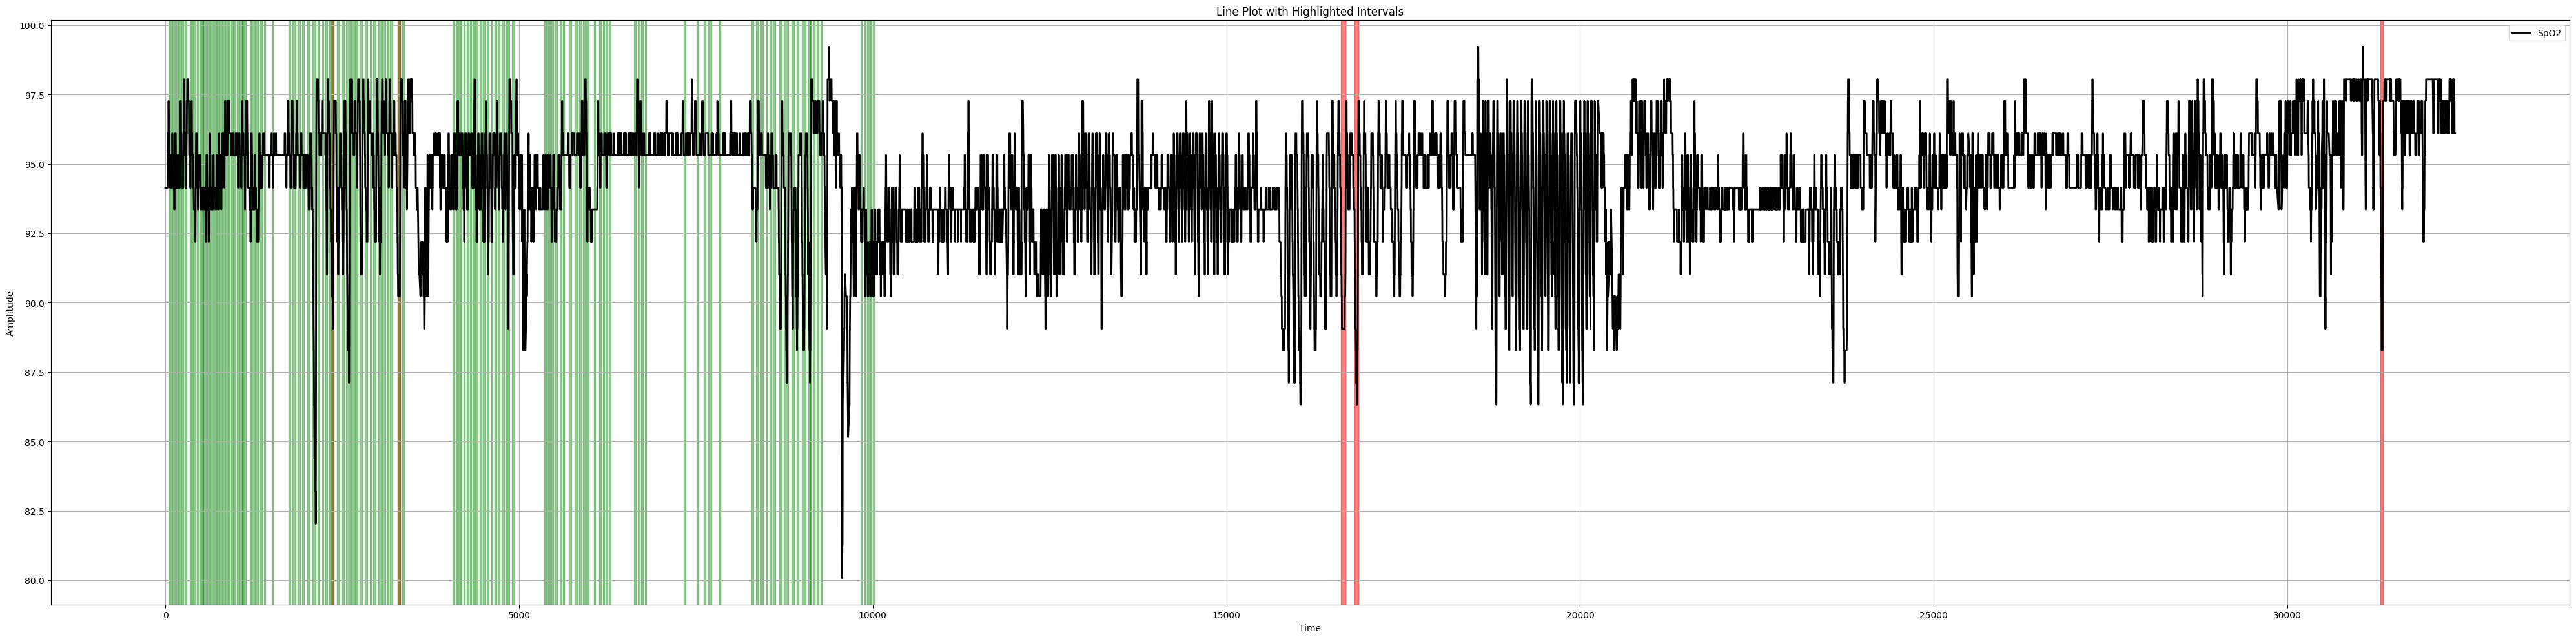

In [23]:
import plotly.graph_objects as go


def plot_compare_anot(y_data, on_pred, off_pred, on_true, off_true, second_channel=None):
    # # Create the line plot
    # fig = go.Figure()

    # # Add the main line
    # fig.add_trace(go.Scatter(x=list(range(len(y_data))), y=y_data, mode="lines", name="SpO2", line=dict(color="black", width=2, dash="solid")))

    # if second_channel is not None:
    #     fig.add_trace(go.Scatter(x=list(range(len(y_data))), y=second_channel, mode="lines", name="HR", line=dict(color="purple", width=2, dash="solid")))
    
    # # Add highlighted intervals
    # for start, end in zip(on_pred, off_pred):
    #     fig.add_shape(
    #         type="rect",
    #         x0=start,
    #         x1=end,
    #         y0=y_data.min(),
    #         y1=y_data.max(),
    #         fillcolor="red",  # Semi-transparent red
    #         opacity=0.5,
    #         line_width=0,
    #     )

    # for onset, offset in zip(on_true, off_true):
    #     fig.add_shape(
    #         type="rect",
    #         x0=onset,
    #         x1=offset,
    #         y0=y_data.min(),
    #         y1=y_data.max(),
    #         fillcolor="green",  # Semi-transparent blue
    #         opacity=0.4,
    #         line_width=0,
    #     )


    # # Customize layout
    # fig.update_layout(
    #     title="Line Plot with Highlighted Intervals",
    #     xaxis_title="Time",
    #     yaxis_title="Amplitude",
    #     showlegend=False,
    # )

    # fig.show()
    
    # Create a figure
    plt.figure(figsize=(40, 10))

    # Plot the main channel
    plt.plot(range(len(y_data)), y_data, label="SpO2", color="black", linewidth=2, linestyle="solid")

    # Plot the second channel if provided
    if second_channel is not None:
        plt.plot(range(len(second_channel)), second_channel, label="HR", color="purple", linewidth=2, linestyle="solid")

    # Highlight predicted intervals
    for start, end in zip(on_pred, off_pred):
        plt.axvspan(start, end, color="red", alpha=0.5)

    # Highlight true intervals
    for onset, offset in zip(on_true, off_true):
        plt.axvspan(onset, offset, color="green", alpha=0.4)

    # Customize the plot
    plt.title("Line Plot with Highlighted Intervals")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

    # Save and show the plot
    plt.tight_layout()
    plt.show()





plot_compare_anot(dataa[0], on_pred, off_pred, onsett, offsett)

# Put it all together

In [24]:
from multiprocessing import Pool, cpu_count

def process_record(args):
    record, rawedf = args
    SpO2, PR = interpolate_bad_samples(rawedf)
    desaturation_events = detect_desaturation_events(SpO2)
    SpO2 = sub_mean(SpO2)
    PR = standardize(PR)
    return {
        "Record": record,
        "SpO2,PR": np.vstack((SpO2, PR)),
        "Desat": desaturation_events,
        "Annot": rawedf.annotations,
    }

# Parallelize processing
def process_all_records(selected_records):
    with Pool(cpu_count() - 4) as pool:
        results = list(tqdm(pool.imap(process_record, selected_records.items()), total=len(selected_records)))
    
    # Convert results to a DataFrame
    df = pd.DataFrame(results)
    return df

# Call the function
df = process_all_records(selected_records)
df

100%|██████████| 20/20 [00:00<00:00, 32.78it/s]


Record                                            SpO2,PR  \
0   shhs1-200001  [[2.8442491880858256, 2.8442491880858256, 2.84...   
1   shhs1-200002  [[-0.26082502566329424, -0.26082502566329424, ...   
2   shhs1-200003  [[-1.6578136701780721, -1.6578136701780721, -1...   
3   shhs1-200004  [[-0.12337872529037952, 1.0485141563759157, 1....   
4   shhs1-200005  [[2.074733218149305, 2.074733218149305, 2.0747...   
5   shhs1-200006  [[2.675111564001867, 2.675111564001867, 2.6751...   
6   shhs1-200007  [[1.475858436901106, 1.475858436901106, 1.4758...   
7   shhs1-200008  [[-0.4084205297330925, -0.4084205297330925, 0....   
8   shhs1-200009  [[1.3834492911275618, 1.3834492911275618, 0.21...   
9   shhs1-200010  [[0.02609154324551355, 0.02609154324551355, 0....   
10  shhs2-200077  [[4.799014008088676, 5.775591409477244, 5.7755...   
11  shhs2-200078  [[2.425469277929821, 2.425469277929821, 2.4254...   
12  shhs2-200079  [[-3.6981696807751803, -3.6981696807751803, -3...   
13  shhs2-200080  [[5.267521253097172, 5.267521253097172, 4.2909...   
14  shhs2-200081  [[5.214839601031159, 5.214839601031159, 5.2148...   
15  shhs2-200082  [[-0.14177660902127798, -0.14177660902127798, ...   
16  shhs2-200086  [[1.6776247341856845, 1.6776247341856845, 1.67...   
17  shhs2-200088  [[1.1079689999548776, 1.1079689999548776, 1.10...   
18  shhs2-200089  [[2.617803280594316, 2.617803280594316, 2.6178...   
19  shhs2-200091  [[1.305725158880307, 1.305725158880307, 1.3057...   

                                                Desat  \
0          ([3776, 8175, 27693], [3830, 8215, 27812])   
1   ([2341, 3281, 16623, 16812, 31313], [2380, 332...   
2                                            ([], [])   
3                                            ([], [])   
4                                            ([], [])   
5                        ([788, 30234], [907, 30307])   
6                                            ([], [])   
7                                  ([23676], [23795])   
8                                  ([29795], [29914])   
9                                            ([], [])   
10                                           ([], [])   
11         ([603, 26837, 28395], [722, 26956, 28514])   
12  ([571, 10157, 10591, 21484, 22938, 30082], [63...   
13                                           ([], [])   
14         ([1754, 6712, 34973], [1860, 6749, 35092])   
15                                           ([], [])   
16                   ([35828, 36272], [35947, 36391])   
17                                           ([], [])   
18                     ([2663, 33579], [2782, 33698])   
19                                 ([36544], [36663])   

                                                Annot  
0   ({'onset': 0.0, 'duration': 840.0, 'descriptio...  
1   ({'onset': 0.0, 'duration': 270.0, 'descriptio...  
2   ({'onset': 0.0, 'duration': 5010.0, 'descripti...  
3   ({'onset': 0.0, 'duration': 2460.0, 'descripti...  
4   ({'onset': 0.0, 'duration': 600.0, 'descriptio...  
5   ({'onset': 0.0, 'duration': 3690.0, 'descripti...  
6   ({'onset': 0.0, 'duration': 4200.0, 'descripti...  
7   ({'onset': 0.0, 'duration': 2490.0, 'descripti...  
8   ({'onset': 0.0, 'duration': 5190.0, 'descripti...  
9   ({'onset': 0.0, 'duration': 3420.0, 'descripti...  
10  ({'onset': 0.0, 'duration': 4650.0, 'descripti...  
11  ({'onset': 0.0, 'duration': 1980.0, 'descripti...  
12  ({'onset': 0.0, 'duration': 1470.0, 'descripti...  
13  ({'onset': 0.0, 'duration': 1800.0, 'descripti...  
14  ({'onset': 0.0, 'duration': 7350.0, 'descripti...  
15  ({'onset': 0.0, 'duration': 2520.0, 'descripti...  
16  ({'onset': 0.0, 'duration': 11970.0, 'descript...  
17  ({'onset': 0.0, 'duration': 3750.0, 'descripti...  
18  ({'onset': 0.0, 'duration': 5460.0, 'descripti...  
19  ({'onset': 0.0, 'duration': 6960.0, 'descripti...

shhs1-200001
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     32466
         1.0       0.05      0.20      0.08        54

    accuracy                           0.99     32520
   macro avg       0.52      0.60      0.54     32520
weighted avg       1.00      0.99      0.99     32520



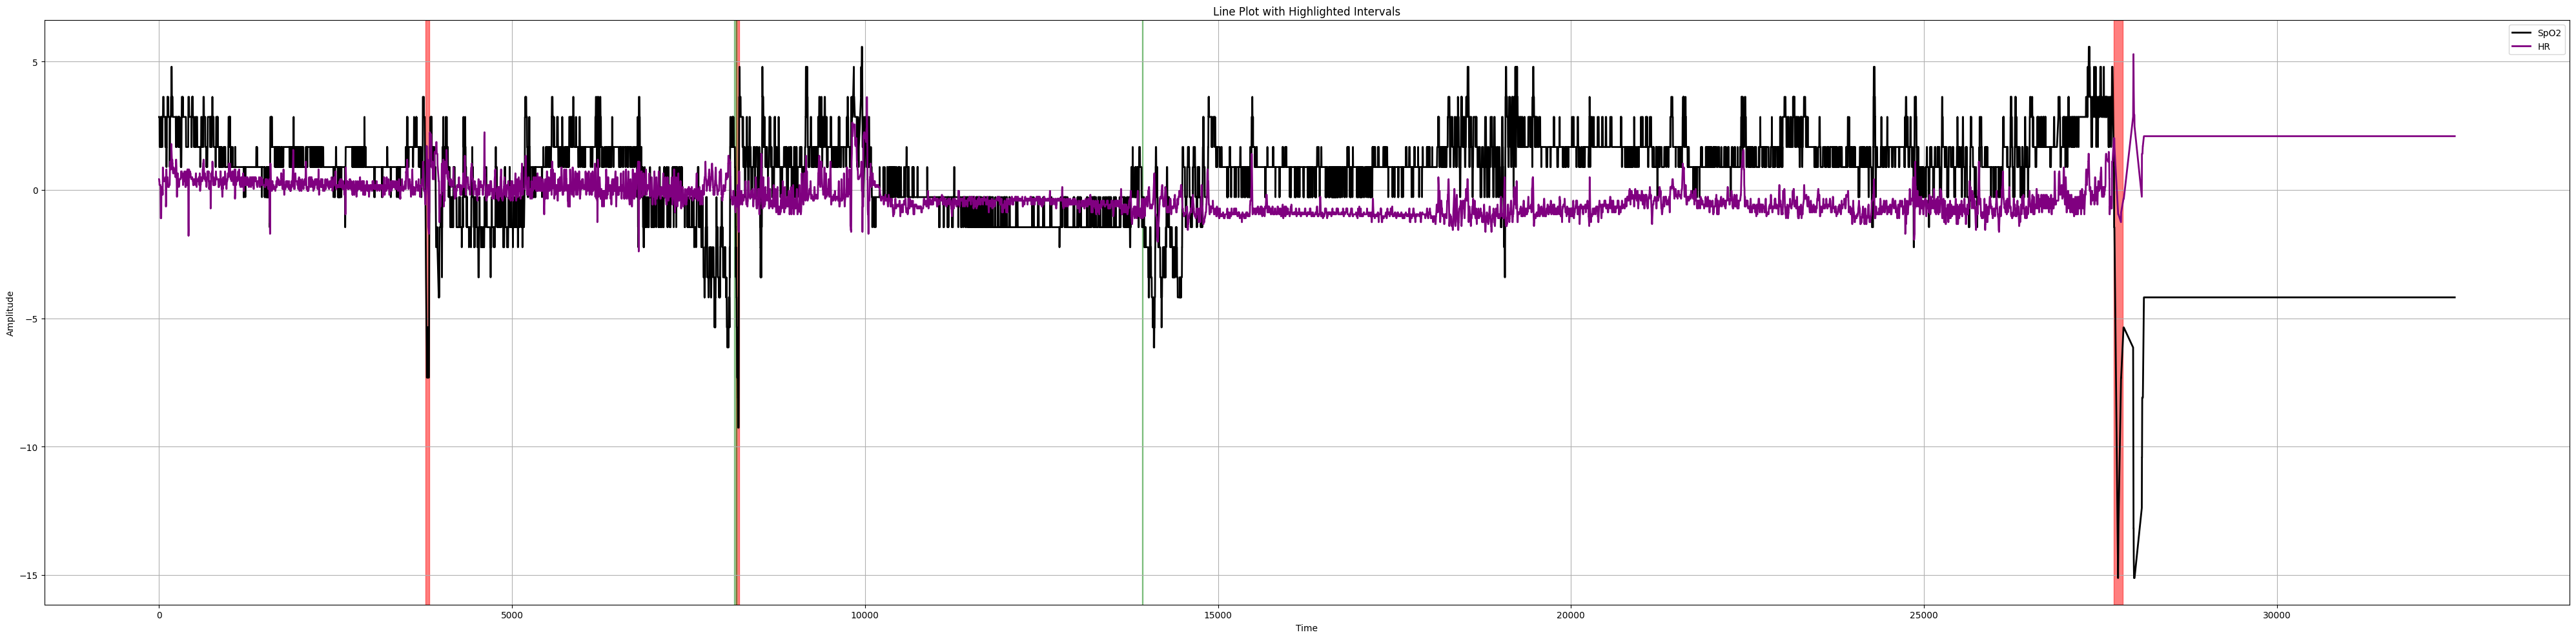

shhs1-200002
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     31797
         1.0       0.00      0.00      0.00       573

    accuracy                           0.98     32370
   macro avg       0.49      0.50      0.49     32370
weighted avg       0.96      0.98      0.97     32370



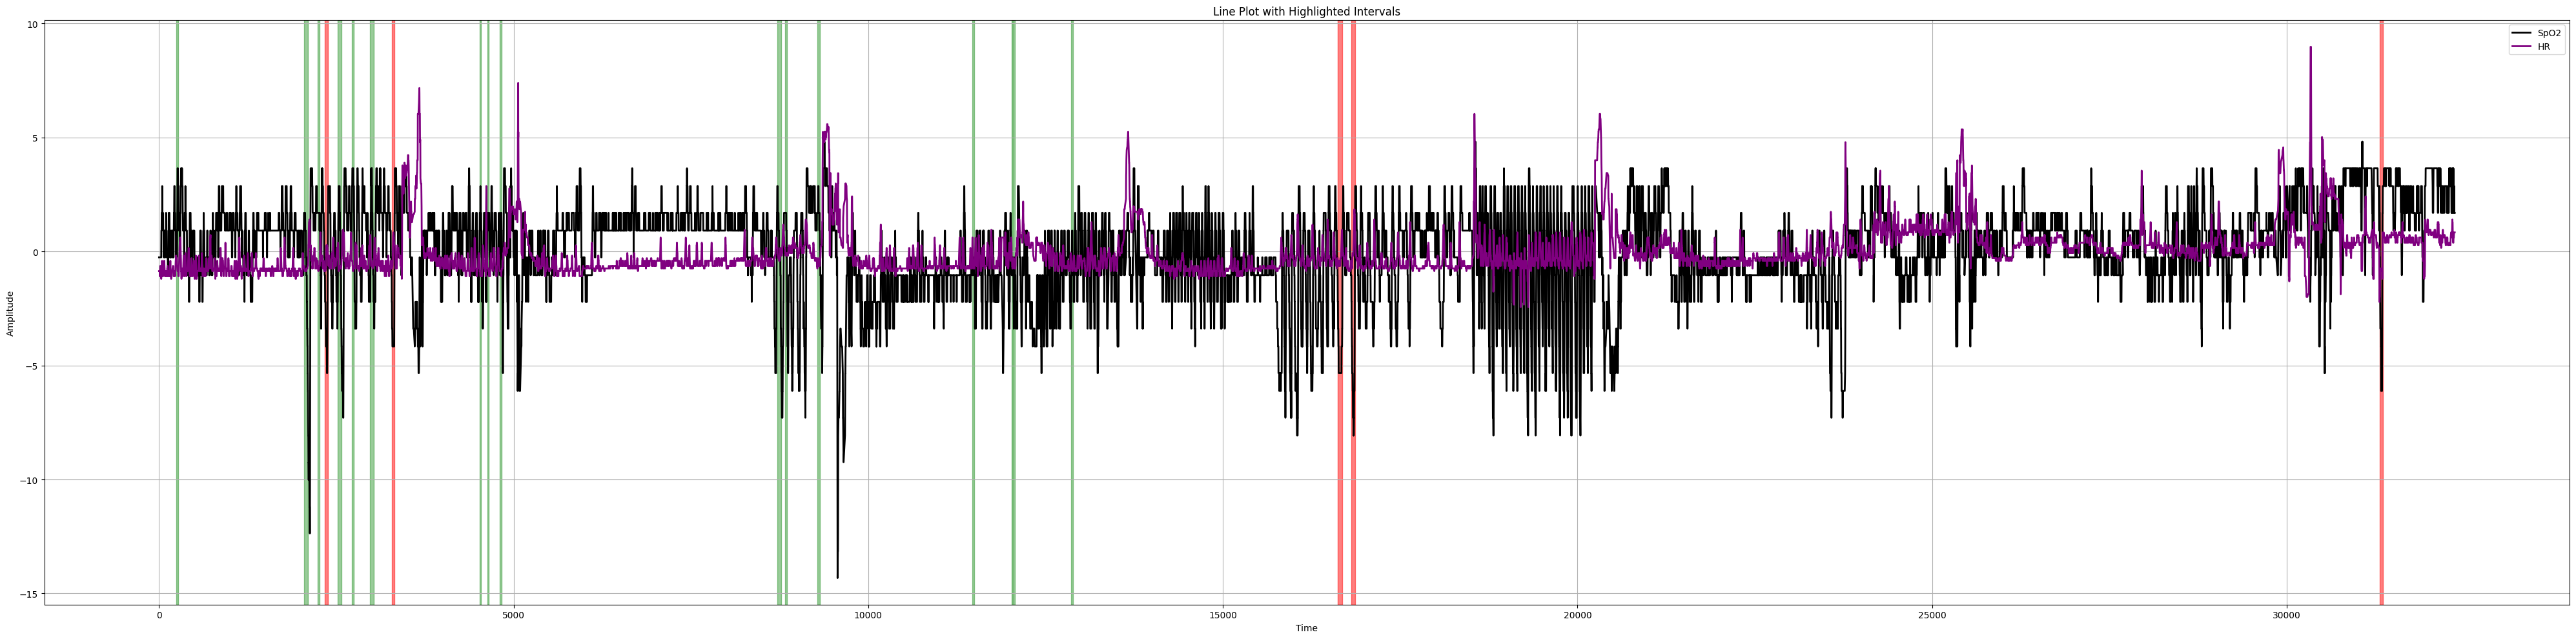

shhs1-200003
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     31361
         1.0       0.00      0.00      0.00       109

    accuracy                           1.00     31470
   macro avg       0.50      0.50      0.50     31470
weighted avg       0.99      1.00      0.99     31470



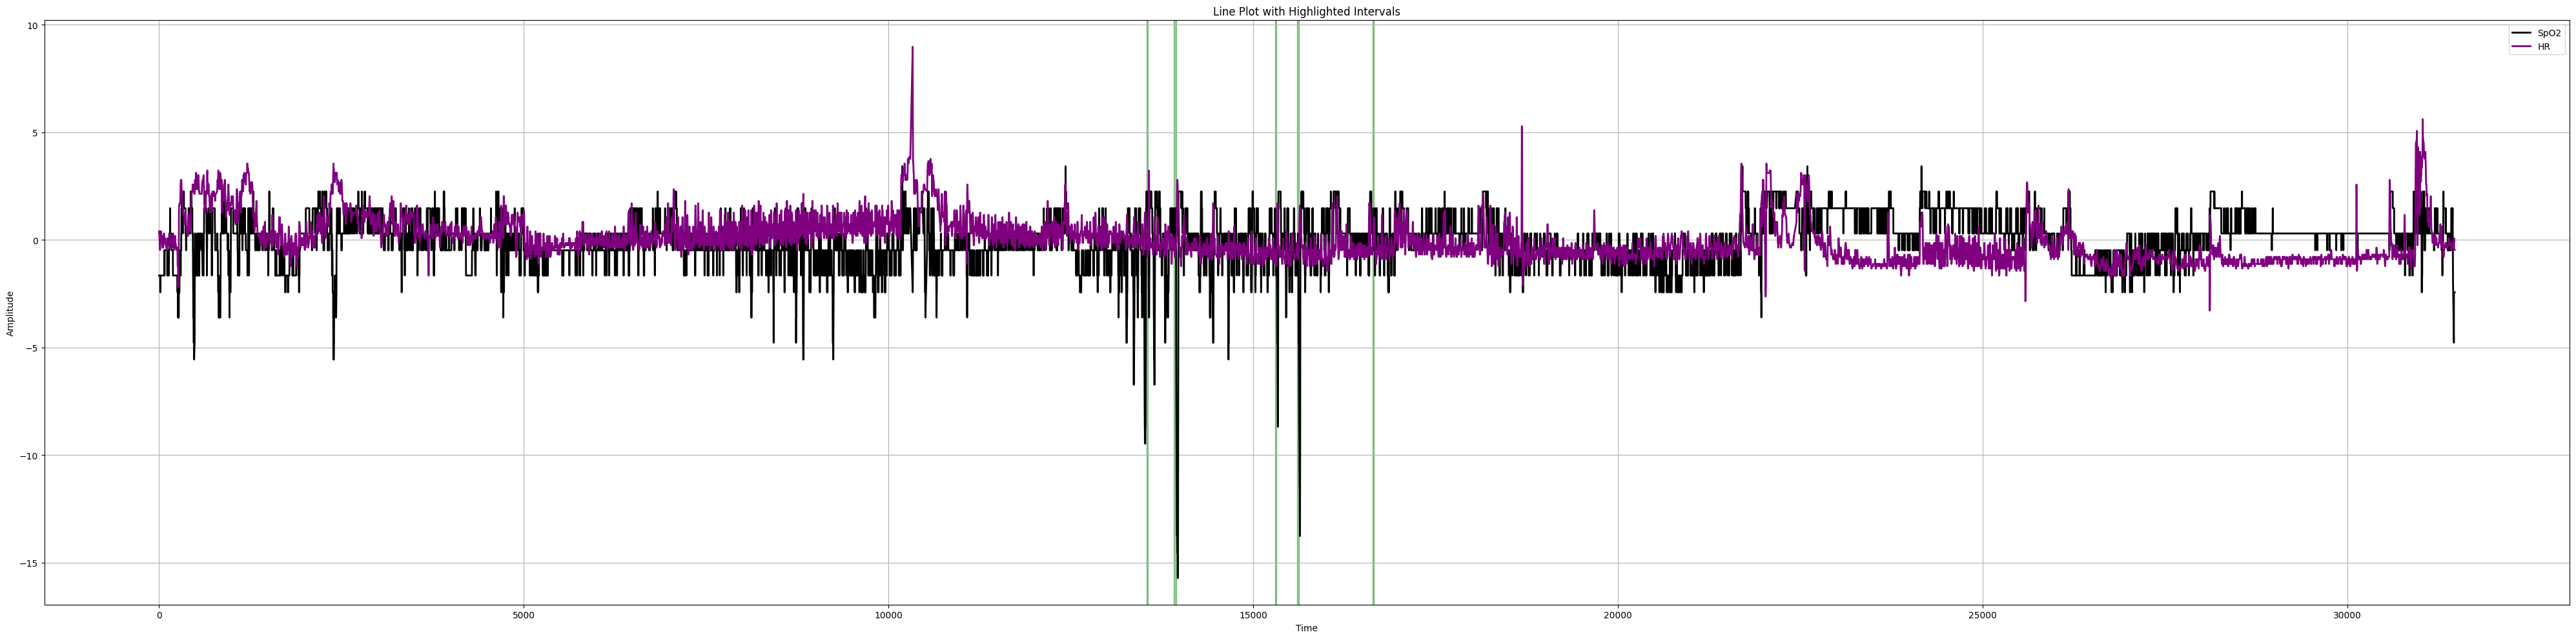

shhs1-200004
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     26064
         1.0       0.00      0.00      0.00       186

    accuracy                           0.99     26250
   macro avg       0.50      0.50      0.50     26250
weighted avg       0.99      0.99      0.99     26250



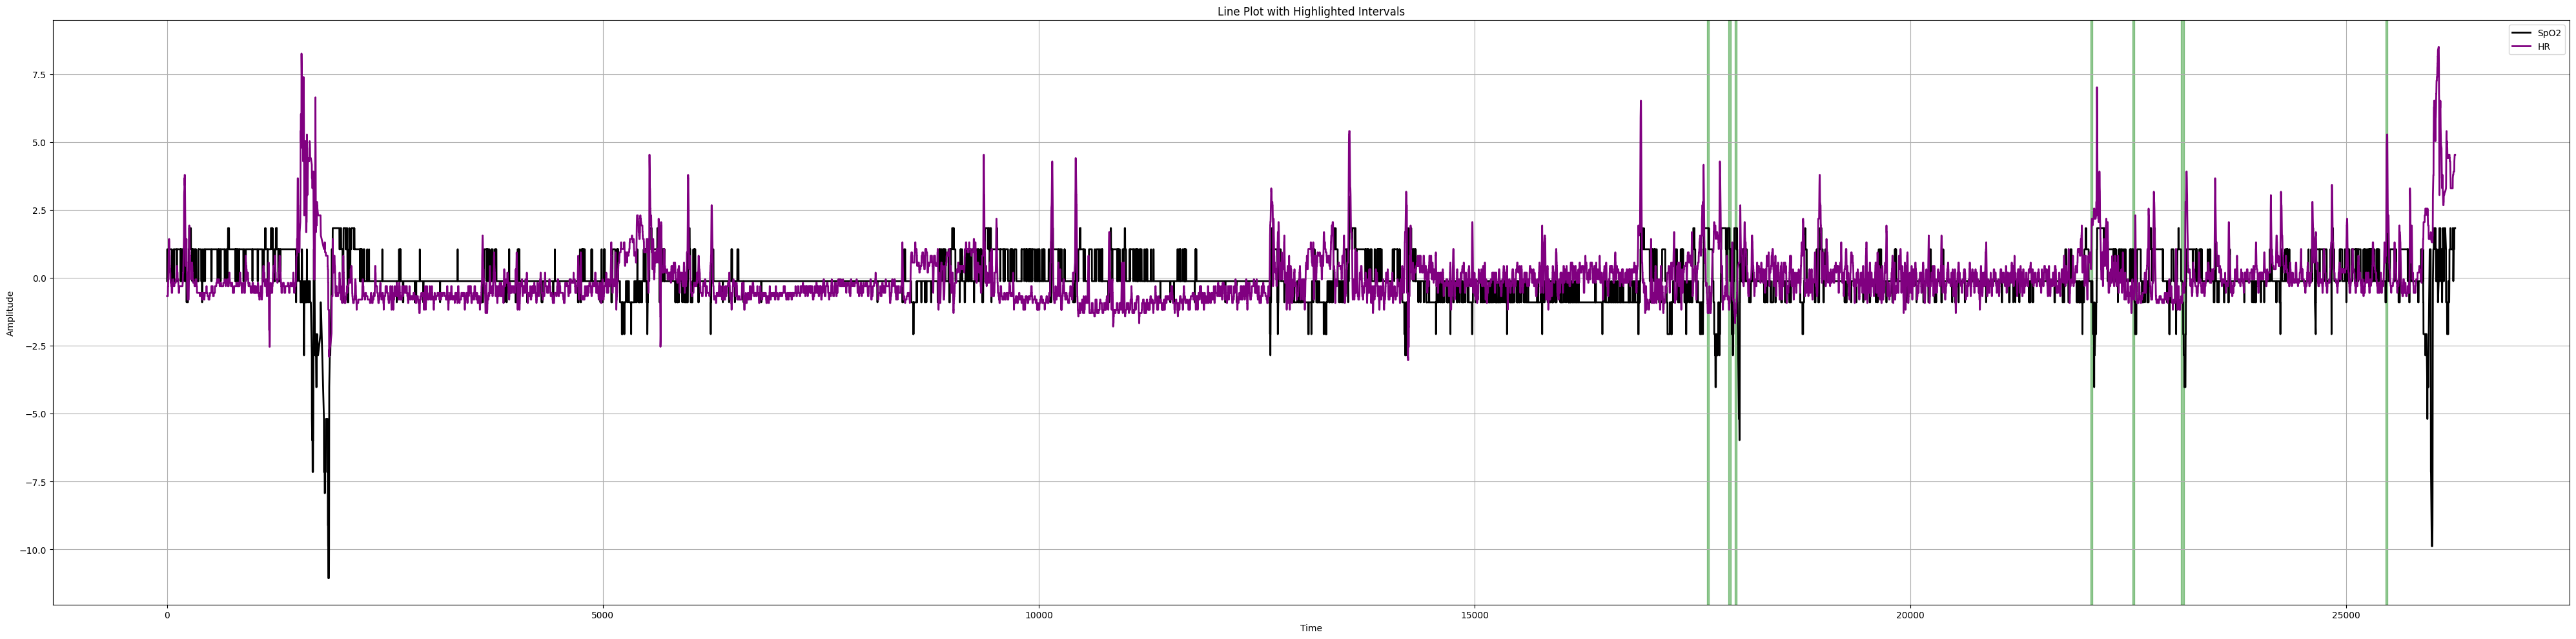

shhs1-200005
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     32445
         1.0       0.00      0.00      0.00        75

    accuracy                           1.00     32520
   macro avg       0.50      0.50      0.50     32520
weighted avg       1.00      1.00      1.00     32520



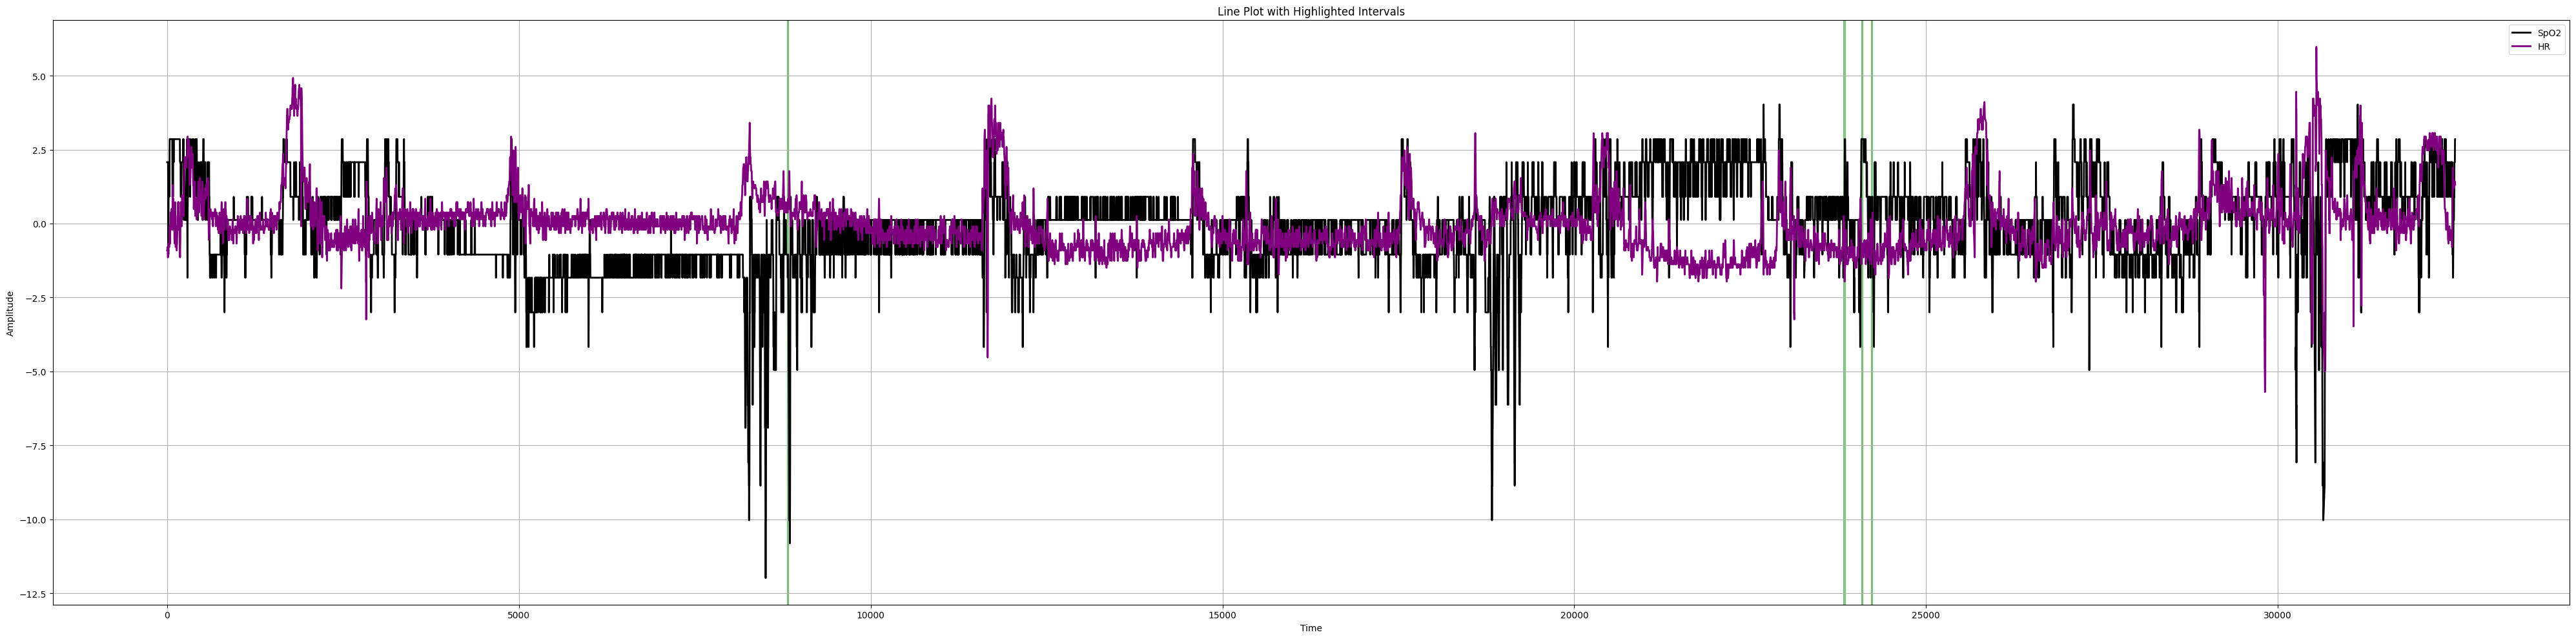

shhs1-200006
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     31986
         1.0       0.00      0.00      0.00       534

    accuracy                           0.98     32520
   macro avg       0.49      0.50      0.49     32520
weighted avg       0.97      0.98      0.97     32520



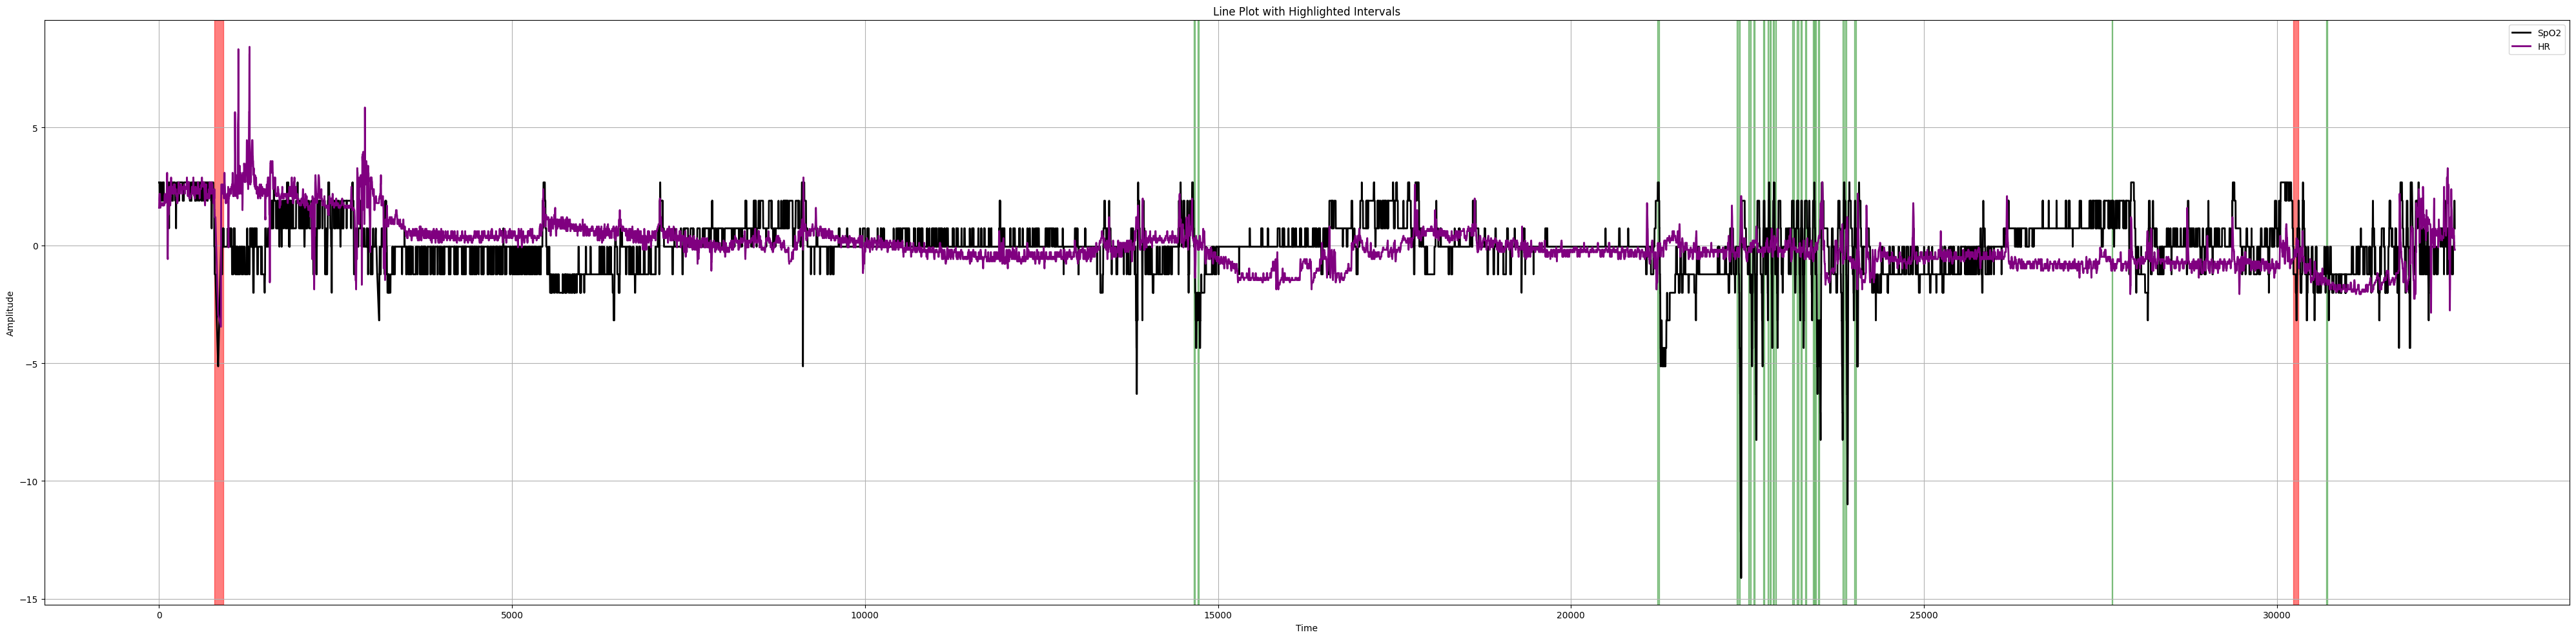

shhs1-200007
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99     26771
         1.0       0.00      0.00      0.00       799

    accuracy                           0.97     27570
   macro avg       0.49      0.50      0.49     27570
weighted avg       0.94      0.97      0.96     27570



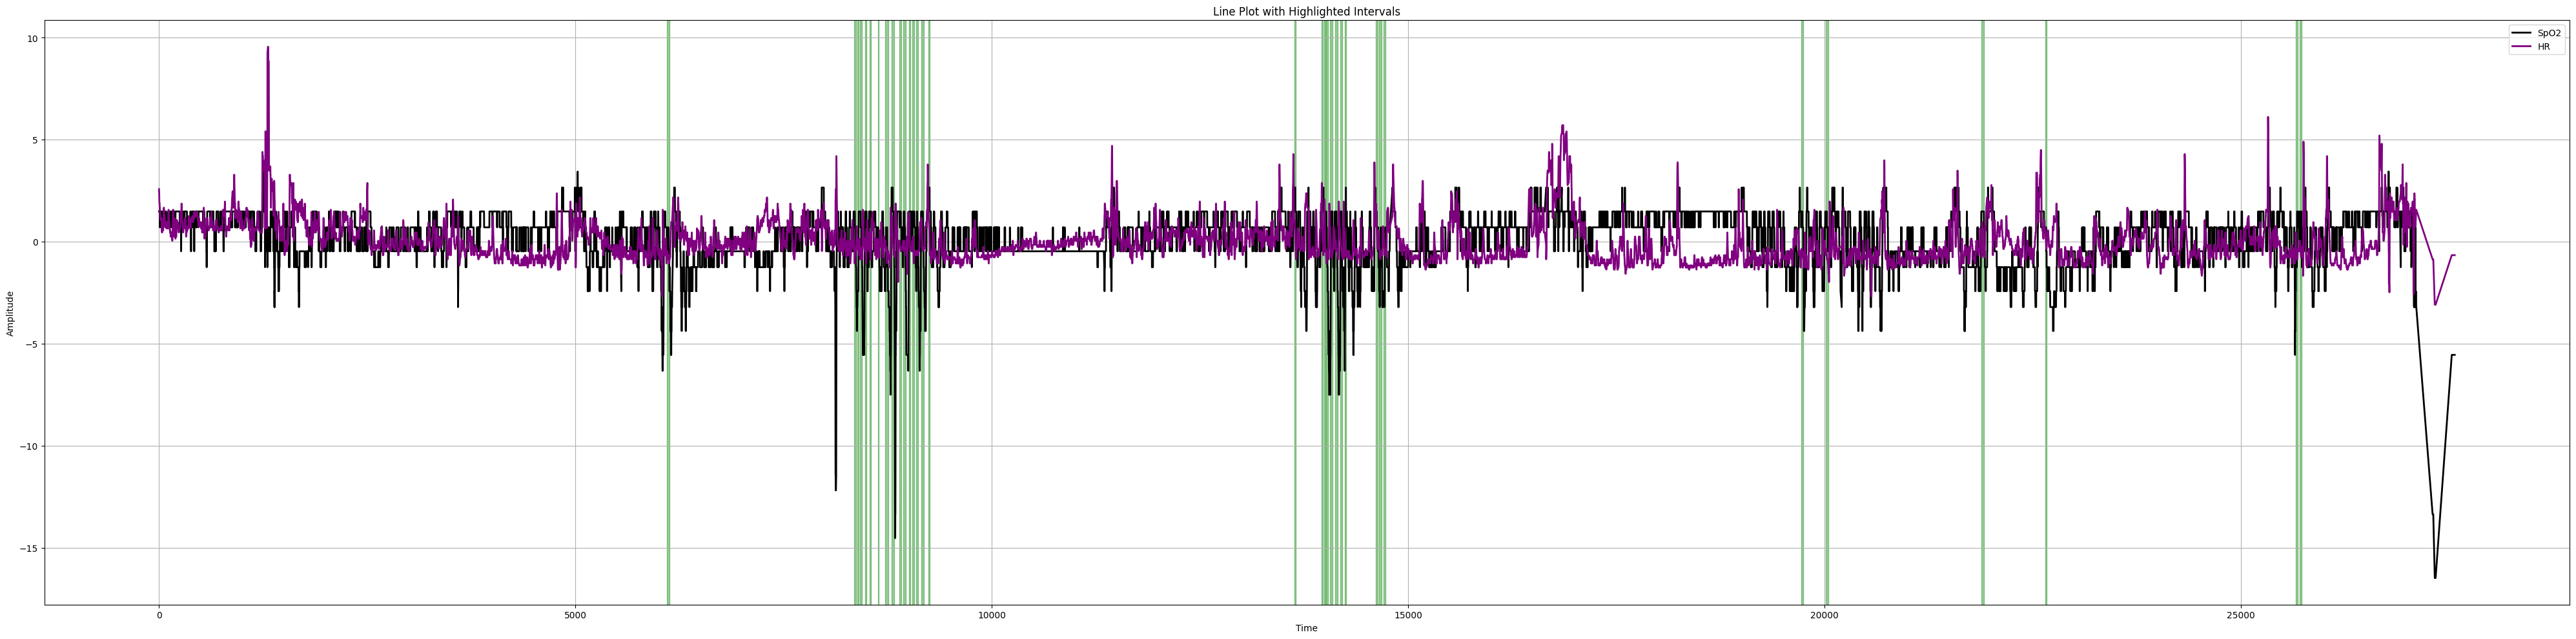

shhs1-200008
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     28659
         1.0       0.00      0.00      0.00       111

    accuracy                           0.99     28770
   macro avg       0.50      0.50      0.50     28770
weighted avg       0.99      0.99      0.99     28770



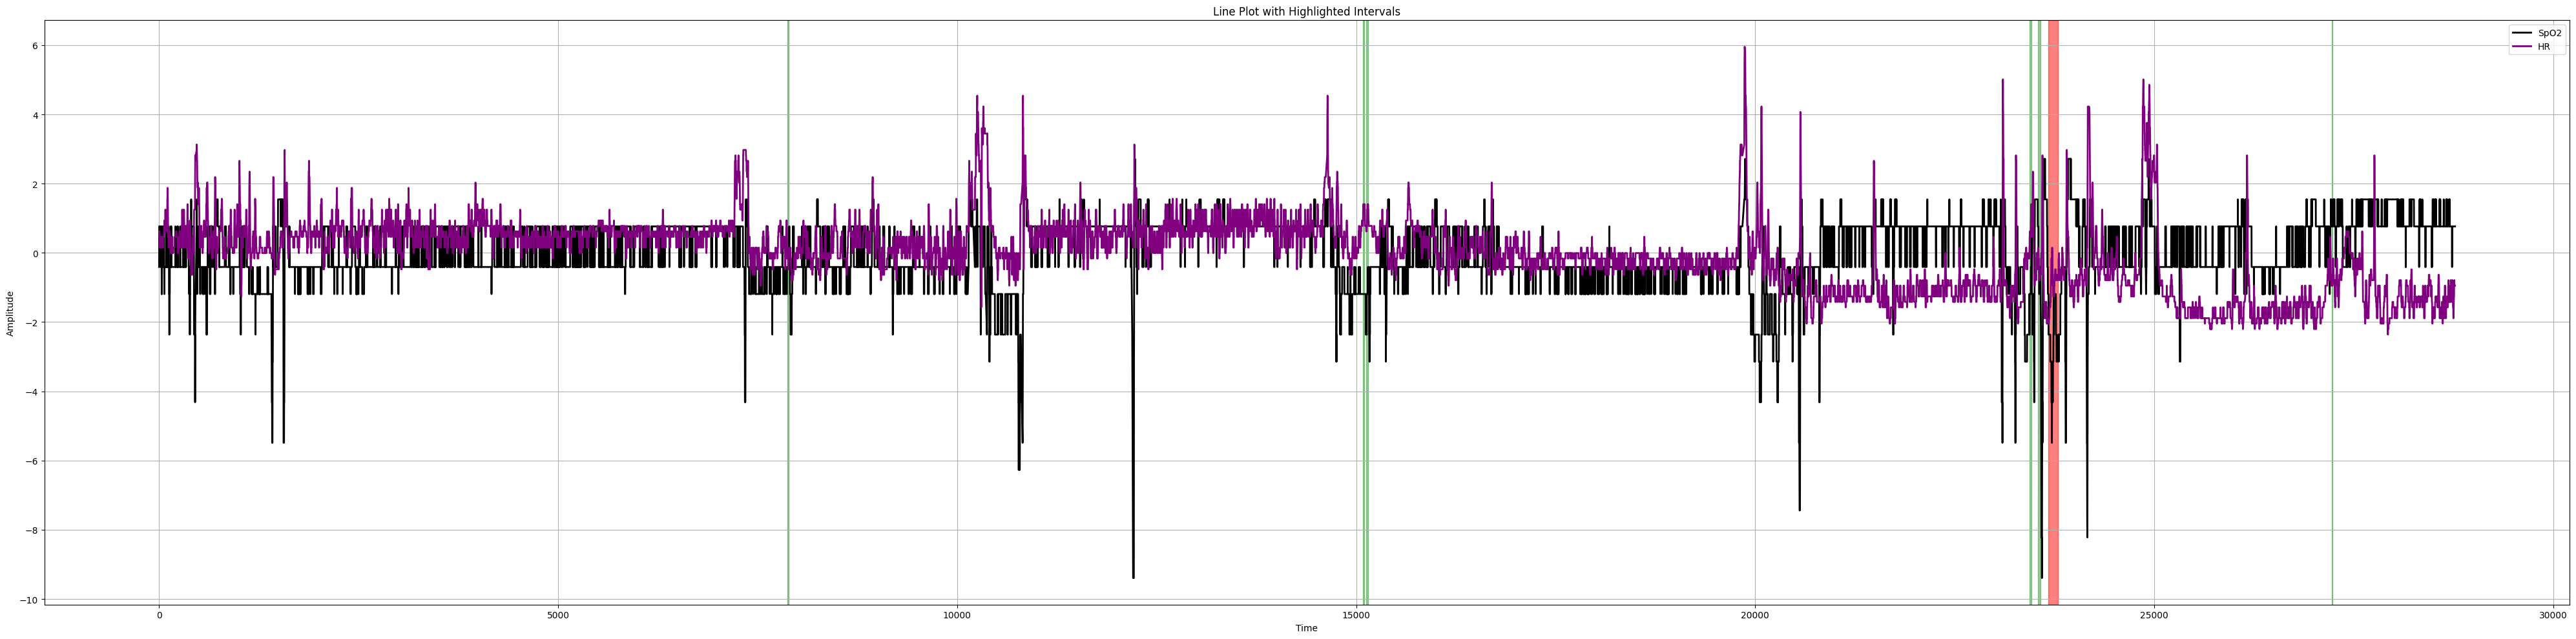

shhs1-200009
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     30294
         1.0       0.00      0.00      0.00      2286

    accuracy                           0.93     32580
   macro avg       0.46      0.50      0.48     32580
weighted avg       0.86      0.93      0.89     32580



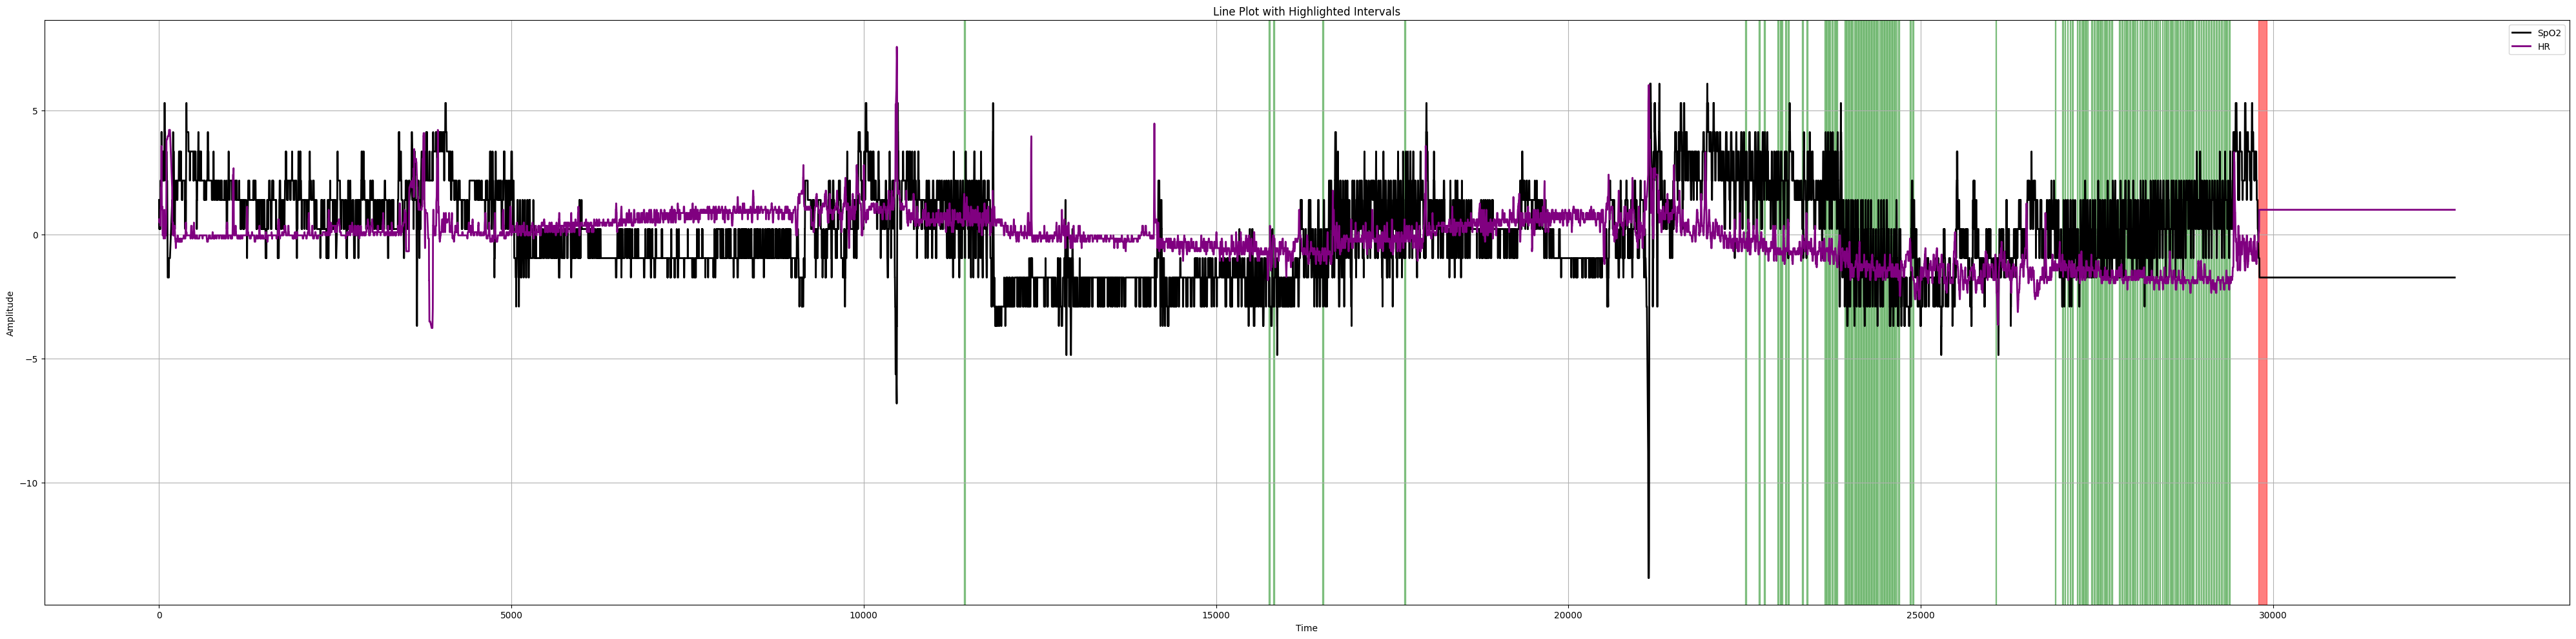

shhs1-200010
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     32520

    accuracy                           1.00     32520
   macro avg       1.00      1.00      1.00     32520
weighted avg       1.00      1.00      1.00     32520



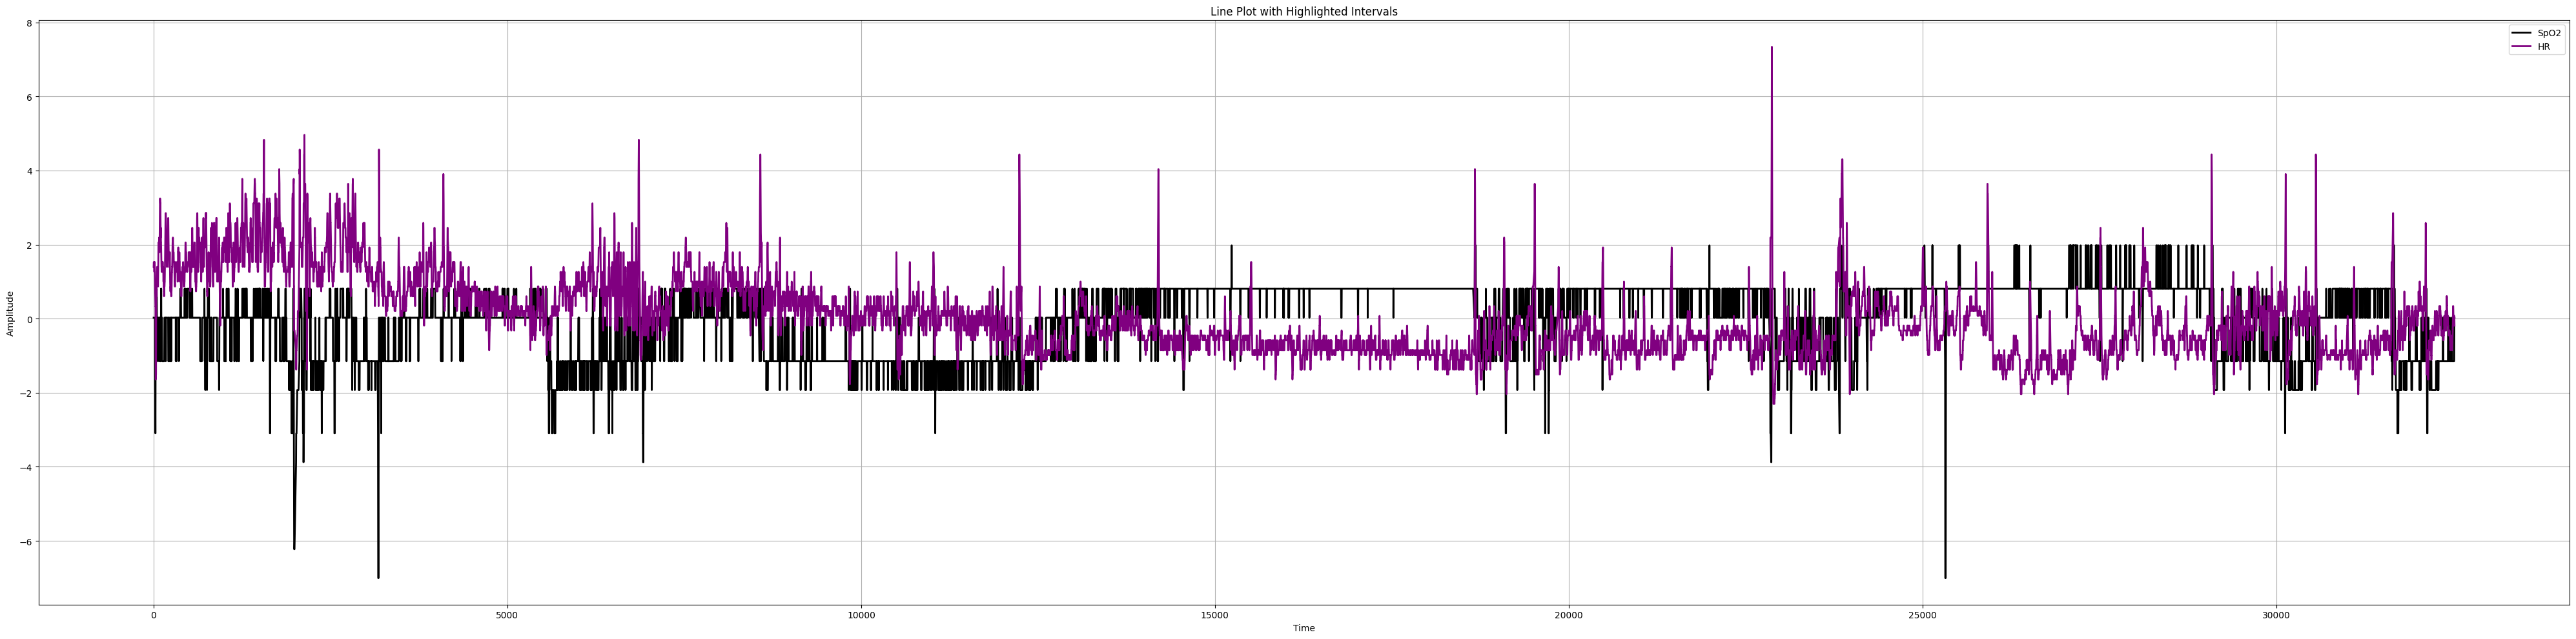

shhs2-200077
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     46108
         1.0       0.00      0.00      0.00       182

    accuracy                           1.00     46290
   macro avg       0.50      0.50      0.50     46290
weighted avg       0.99      1.00      0.99     46290



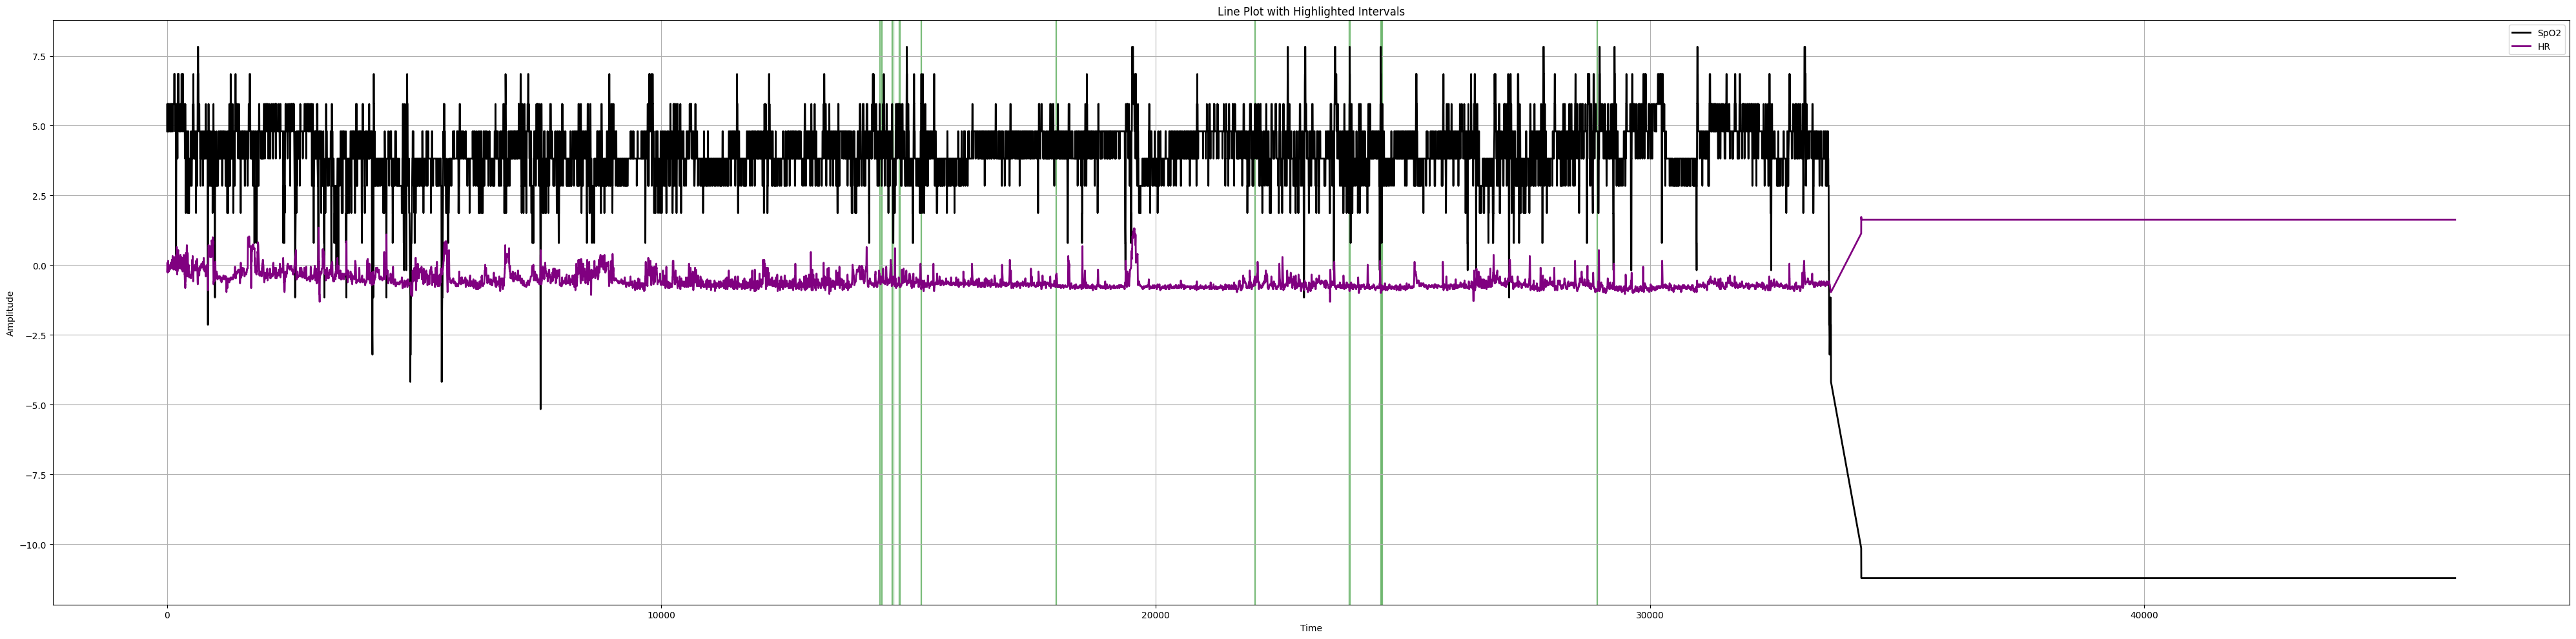

shhs2-200078
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     32934
         1.0       0.00      0.00      0.00       366

    accuracy                           0.98     33300
   macro avg       0.49      0.49      0.49     33300
weighted avg       0.98      0.98      0.98     33300



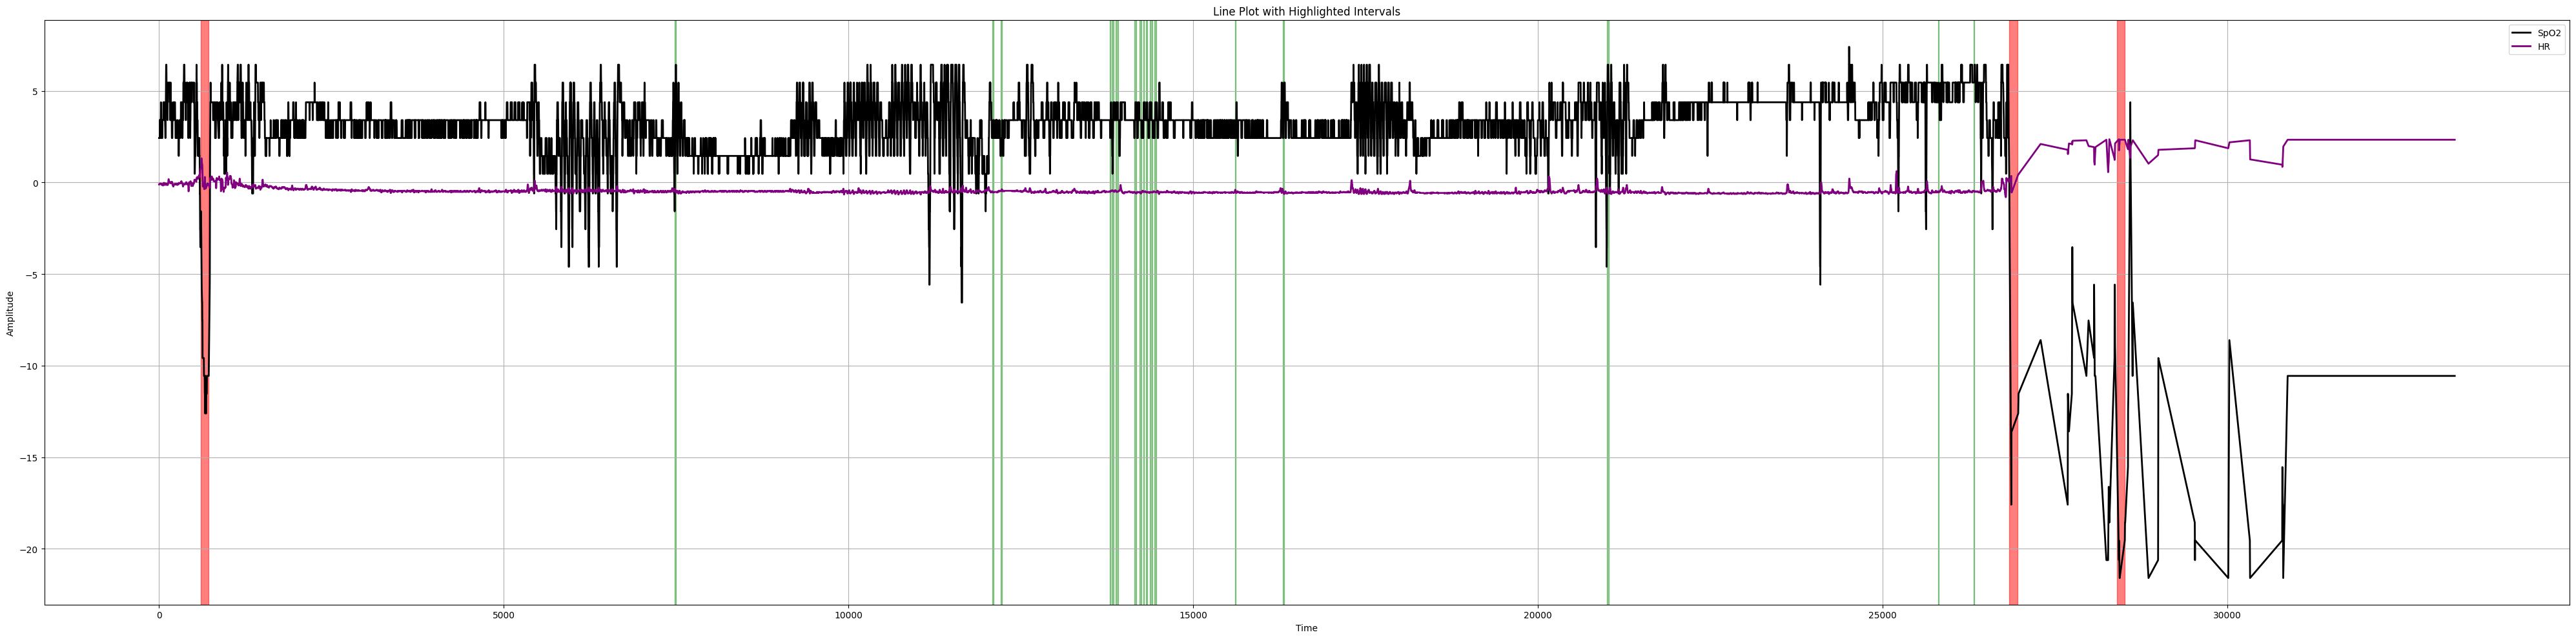

shhs2-200079
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     33625
         1.0       0.10      0.33      0.15       155

    accuracy                           0.98     33780
   macro avg       0.55      0.66      0.57     33780
weighted avg       0.99      0.98      0.99     33780



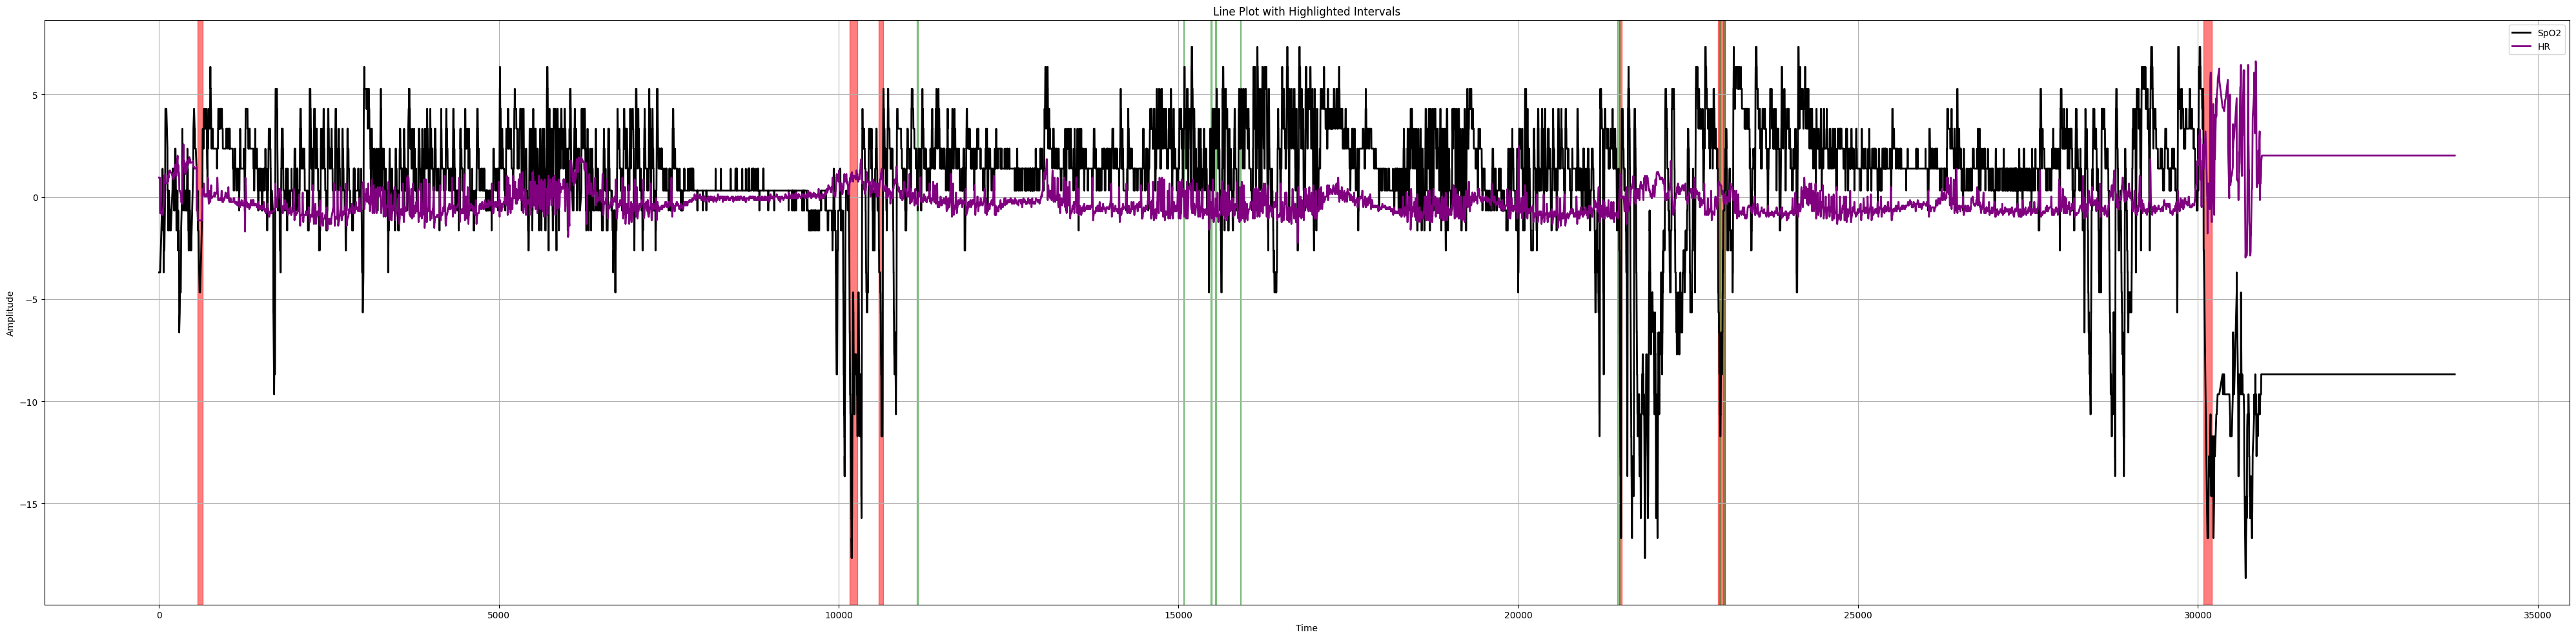

shhs2-200080
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     41234
         1.0       0.00      0.00      0.00       106

    accuracy                           1.00     41340
   macro avg       0.50      0.50      0.50     41340
weighted avg       0.99      1.00      1.00     41340



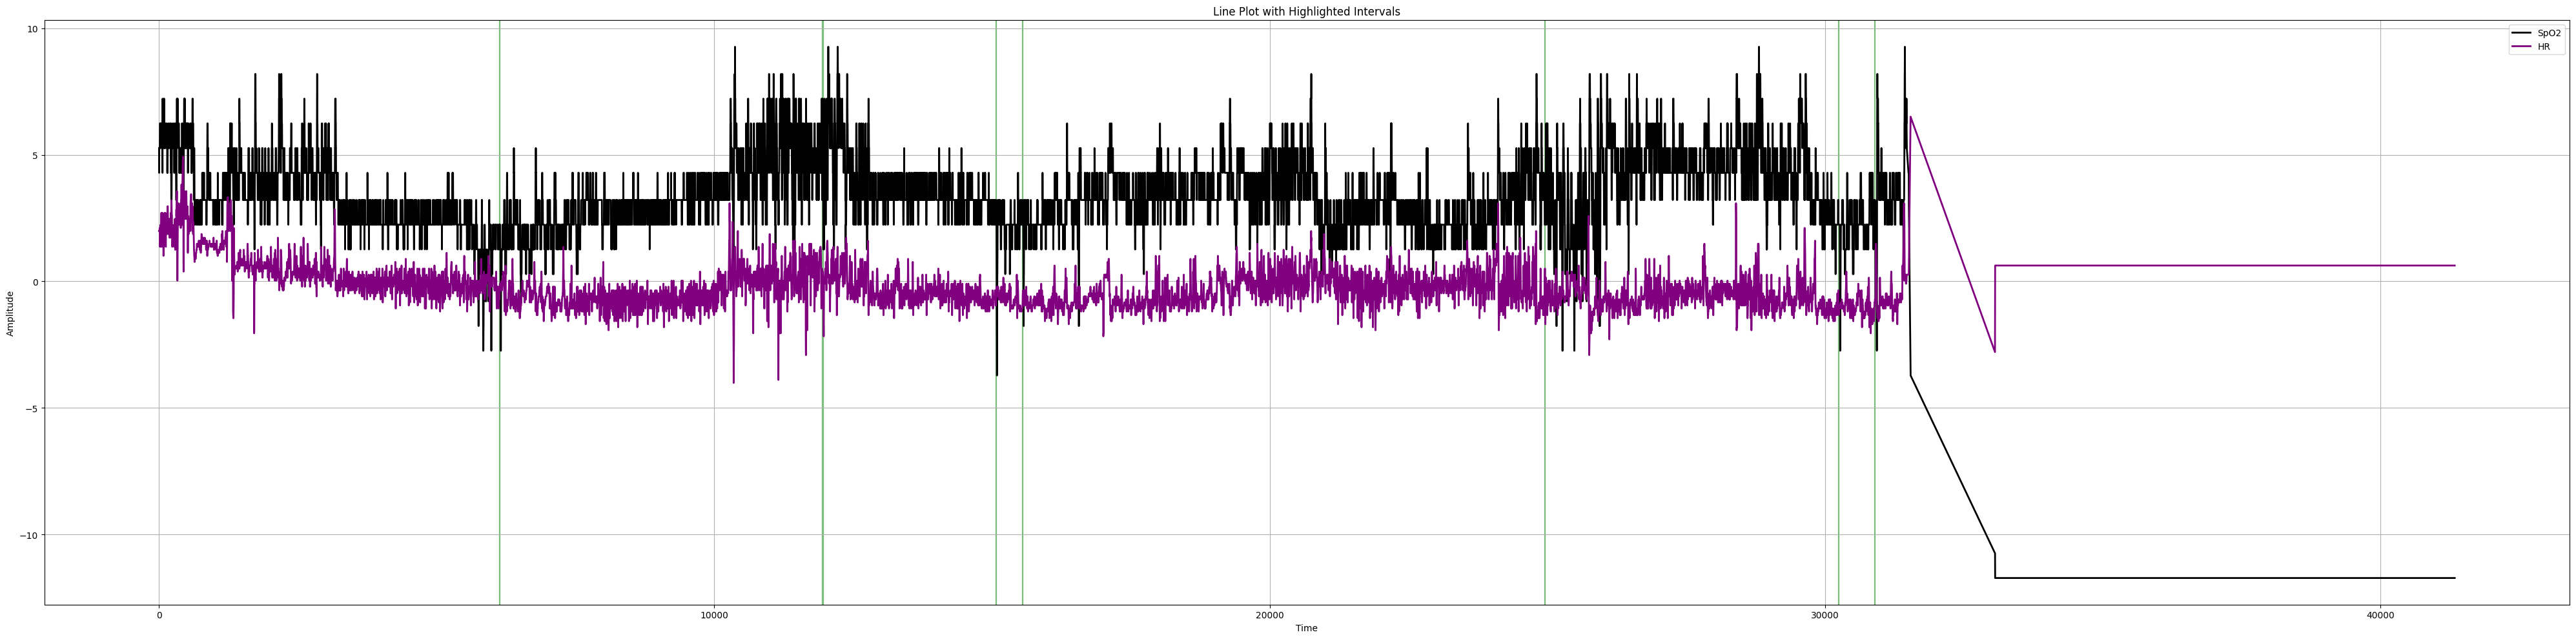

shhs2-200081
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     42561
         1.0       0.00      0.00      0.00        69

    accuracy                           0.99     42630
   macro avg       0.50      0.50      0.50     42630
weighted avg       1.00      0.99      0.99     42630



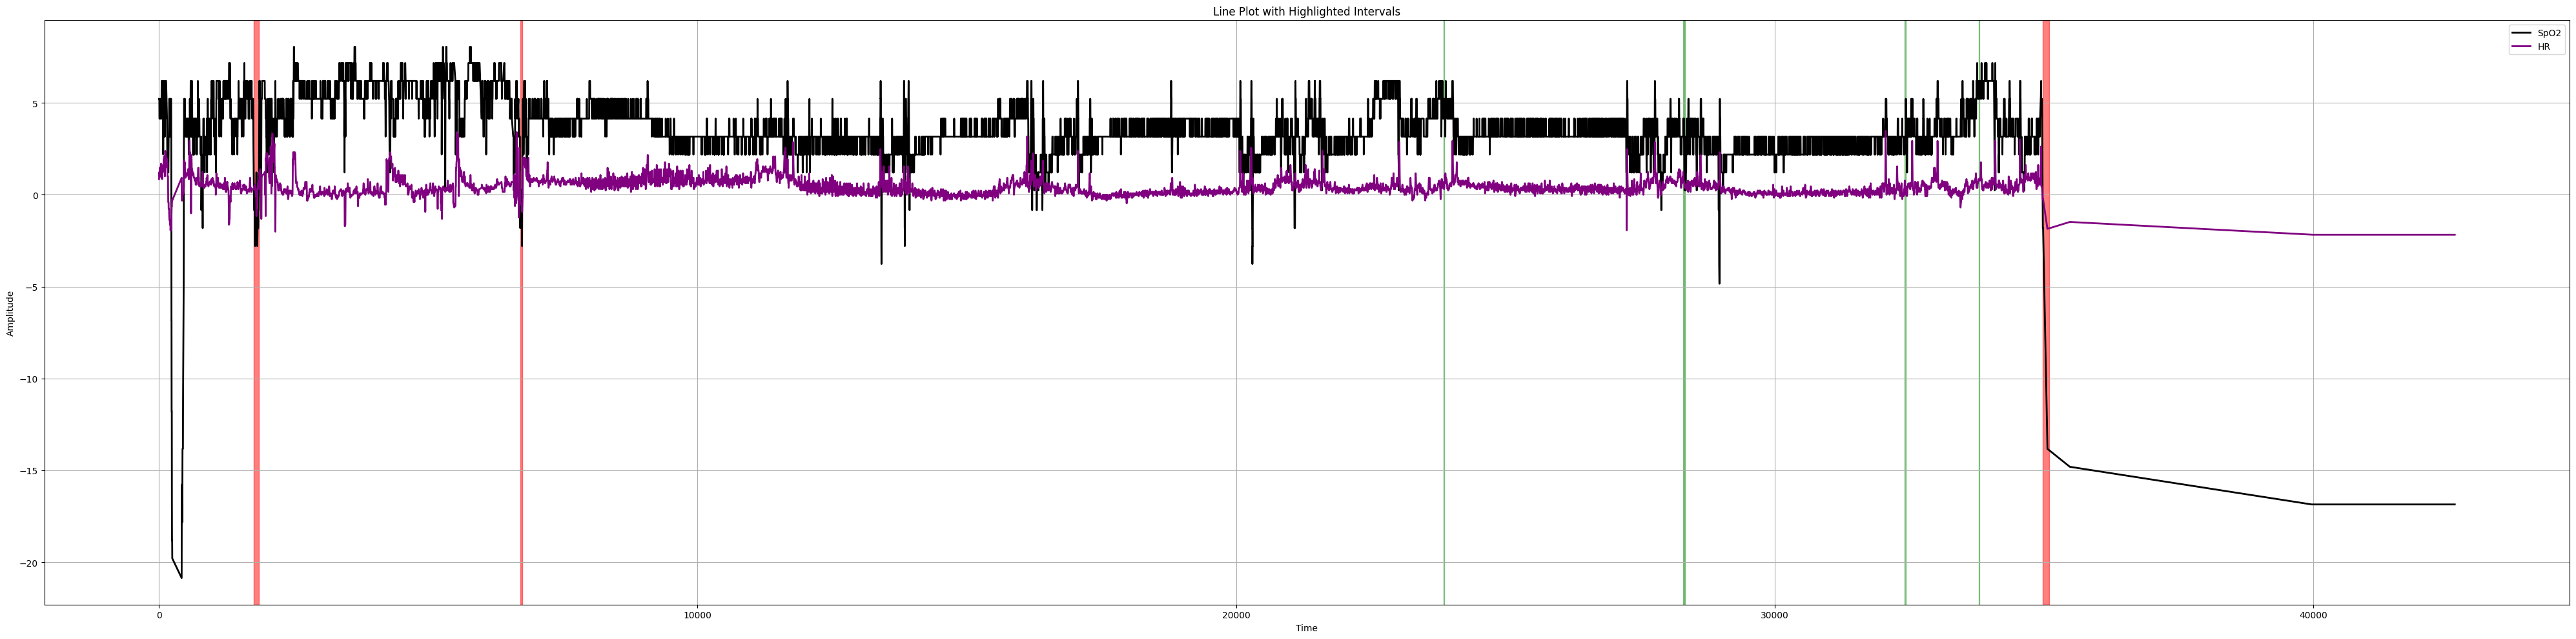

shhs2-200082
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     42755
         1.0       0.00      0.00      0.00       175

    accuracy                           1.00     42930
   macro avg       0.50      0.50      0.50     42930
weighted avg       0.99      1.00      0.99     42930



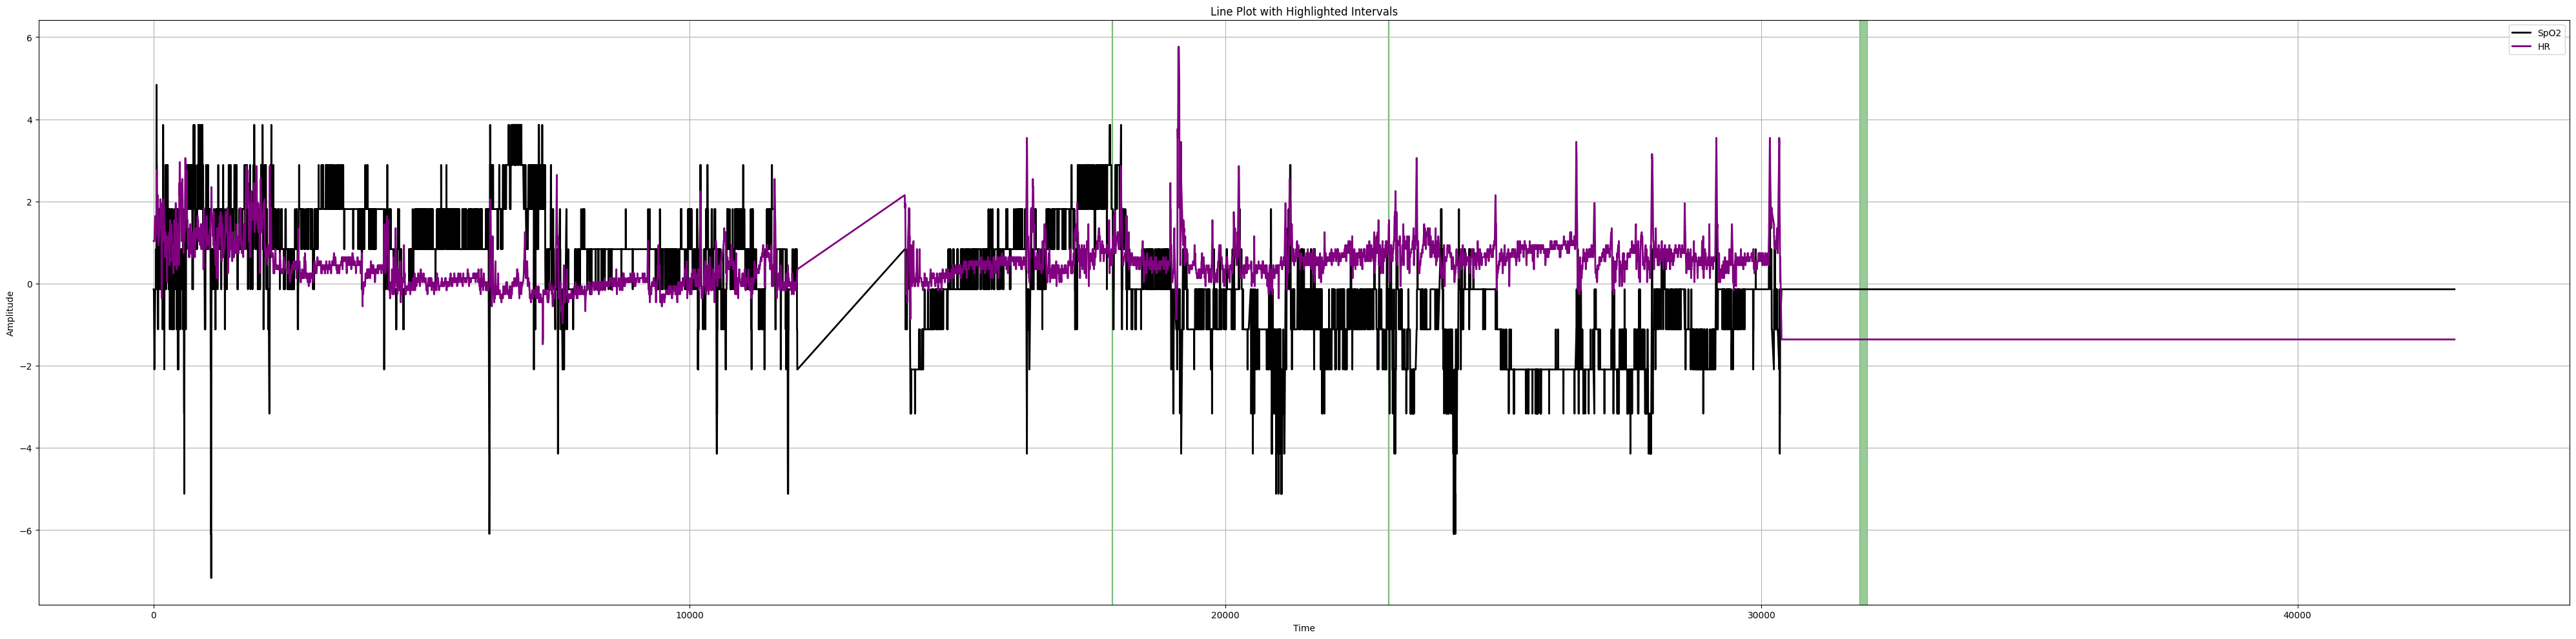

shhs2-200086
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     37727
         1.0       0.00      0.00      0.00      1483

    accuracy                           0.96     39210
   macro avg       0.48      0.50      0.49     39210
weighted avg       0.93      0.96      0.94     39210



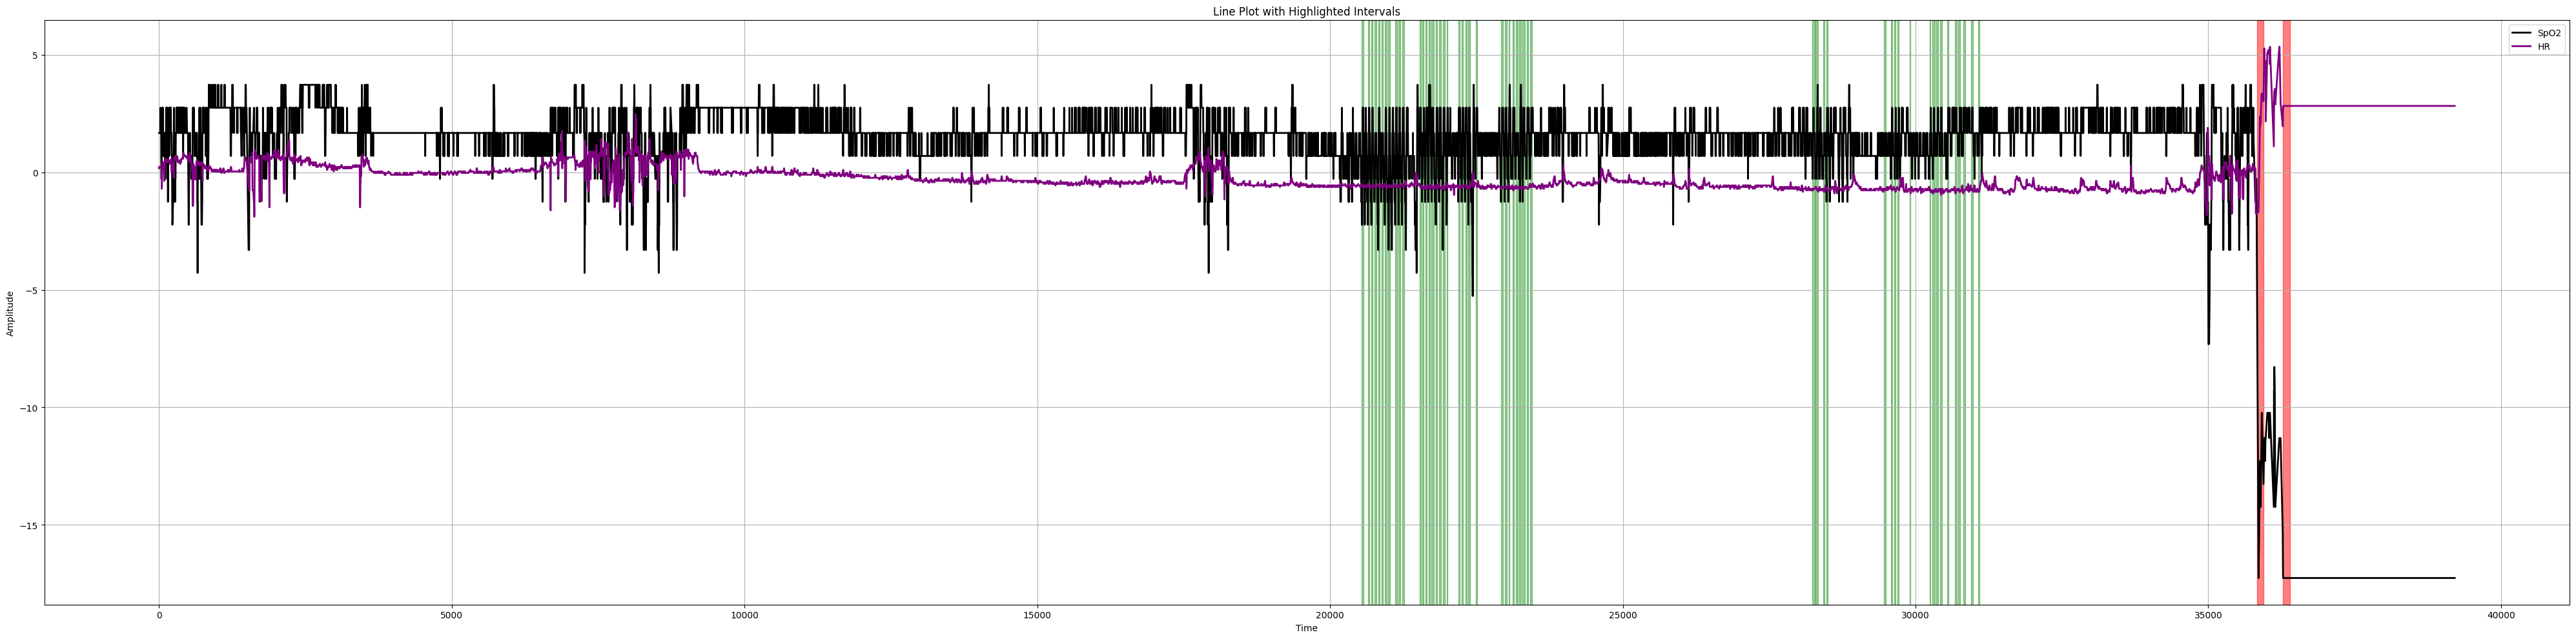

shhs2-200088
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     36197
         1.0       0.00      0.00      0.00        13

    accuracy                           1.00     36210
   macro avg       0.50      0.50      0.50     36210
weighted avg       1.00      1.00      1.00     36210



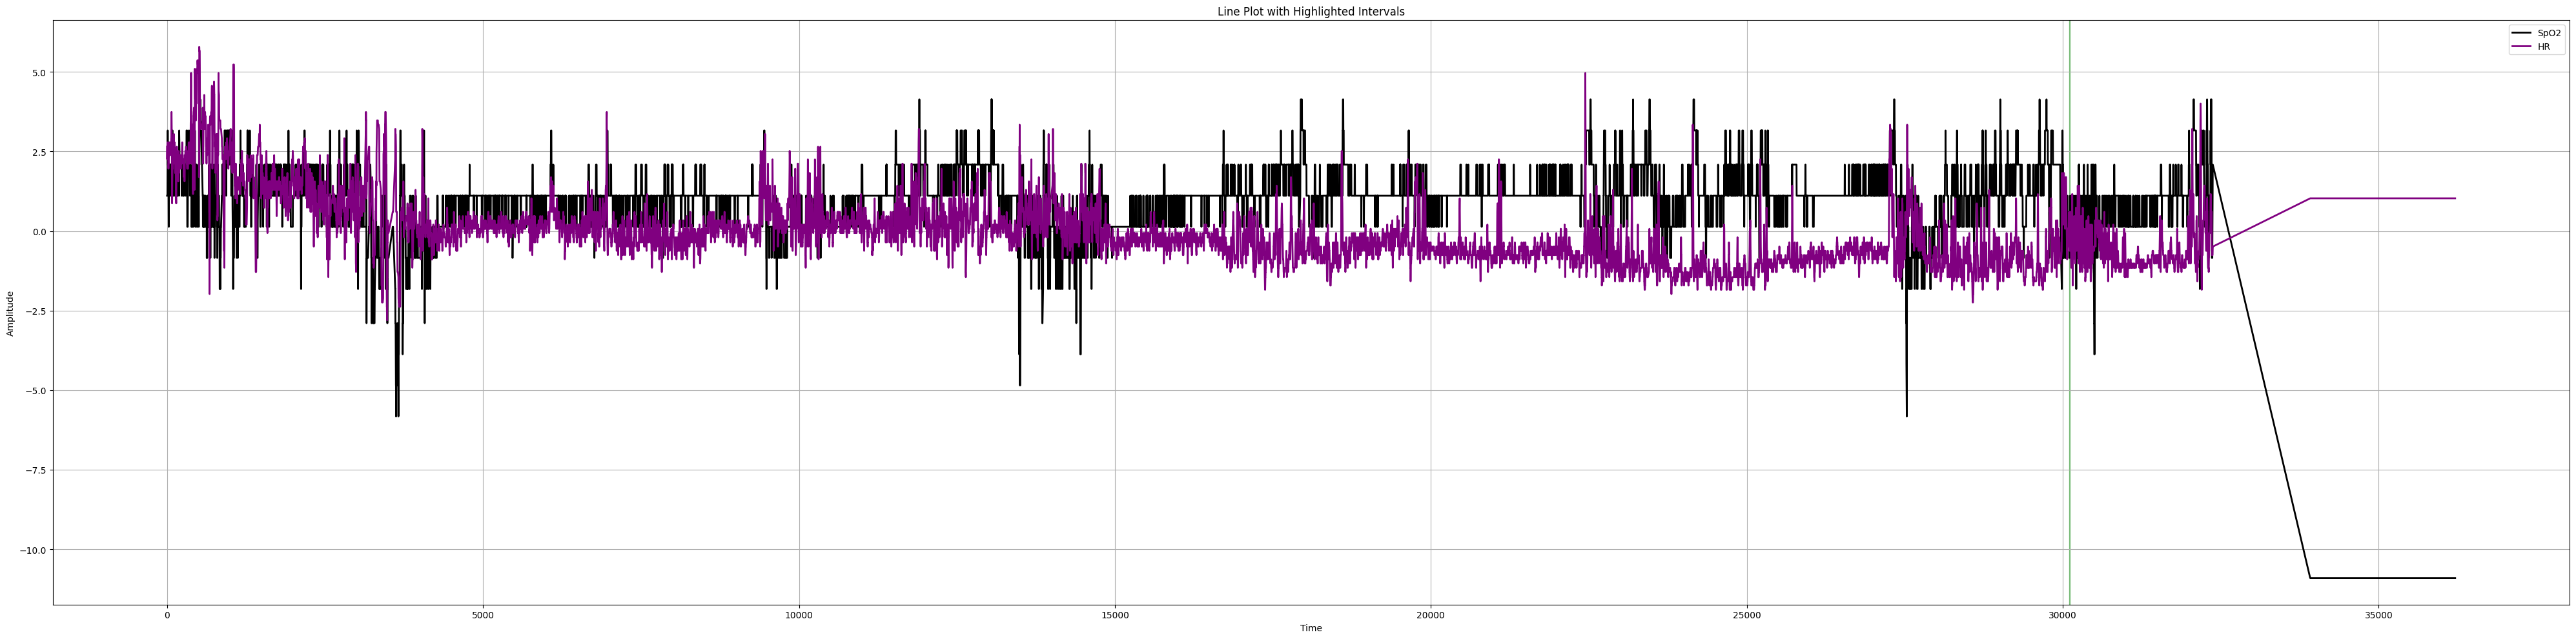

shhs2-200089
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     35037
         1.0       0.00      0.00      0.00       153

    accuracy                           0.99     35190
   macro avg       0.50      0.50      0.50     35190
weighted avg       0.99      0.99      0.99     35190



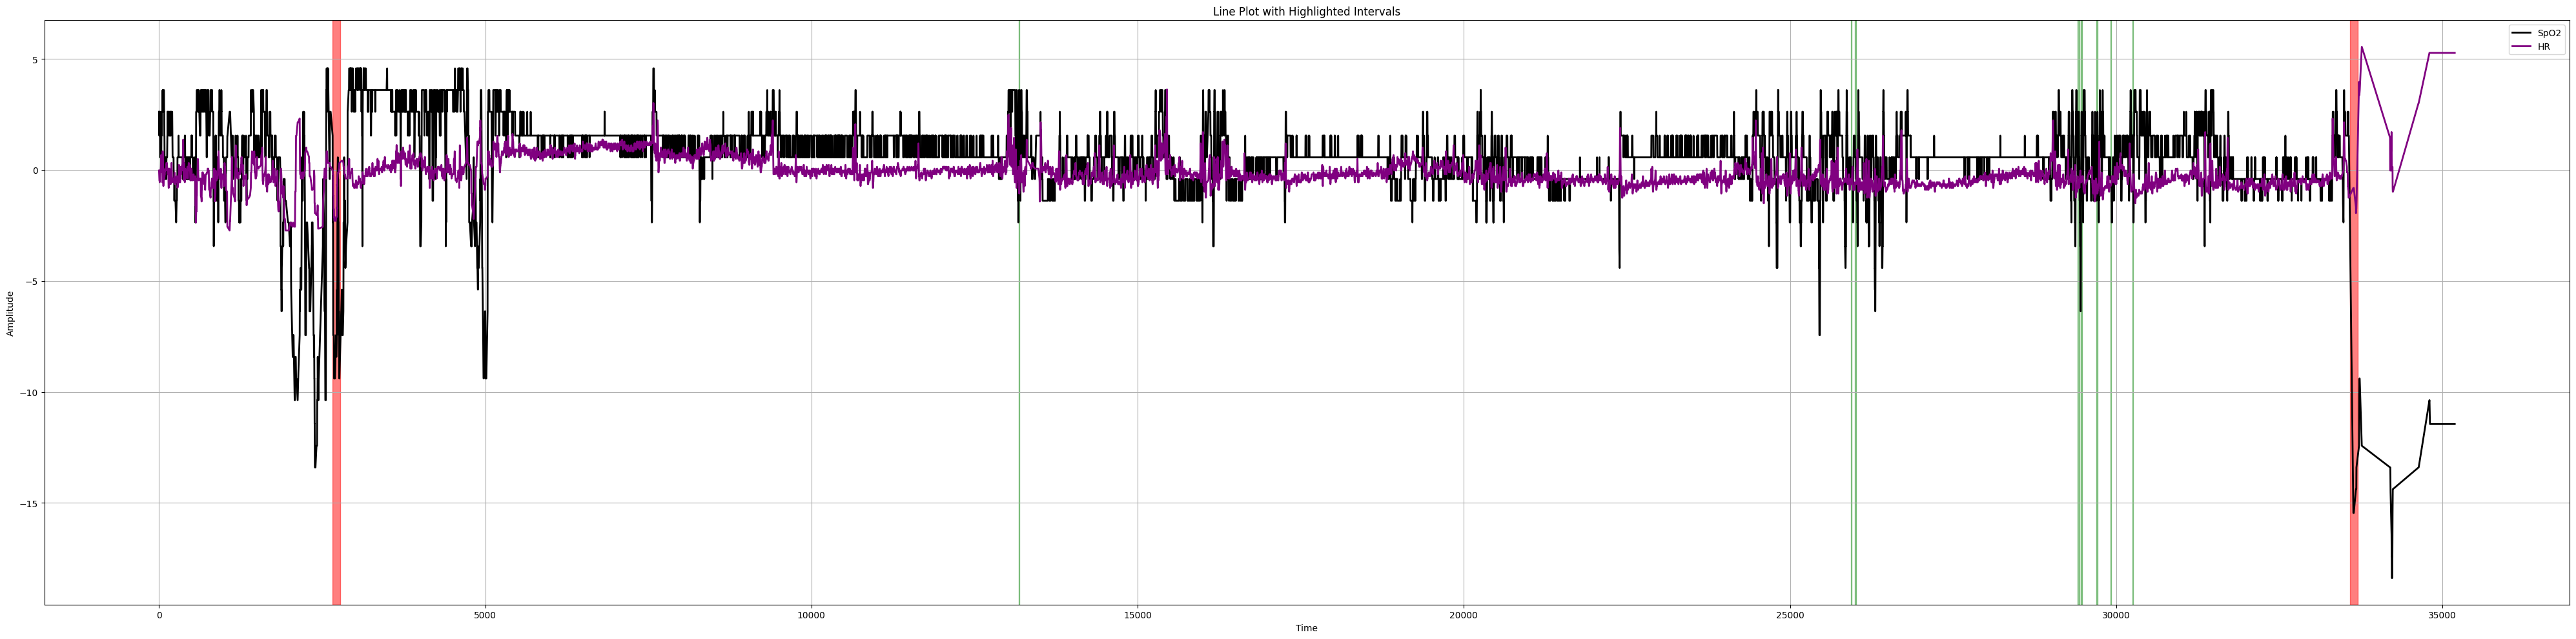

shhs2-200091
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     37559
         1.0       0.00      0.00      0.00       391

    accuracy                           0.99     37950
   macro avg       0.49      0.50      0.50     37950
weighted avg       0.98      0.99      0.98     37950



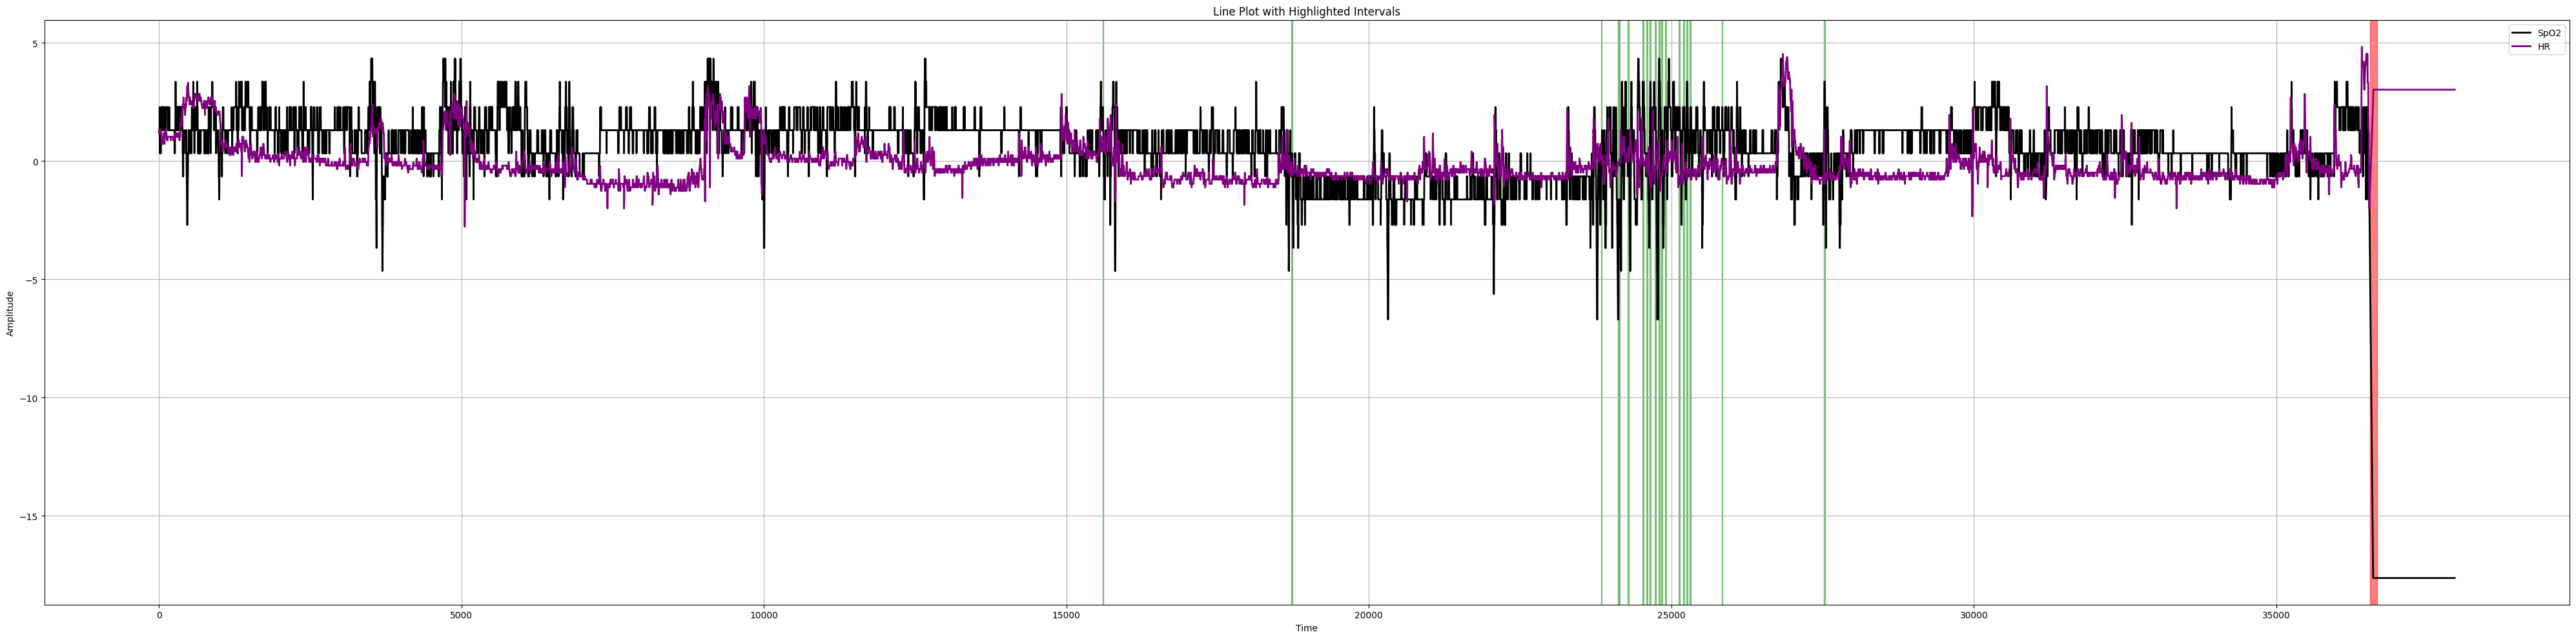

In [25]:
from sklearn.metrics import classification_report

for i, row in df.iterrows():
    # match detected desat with apnea label
    max_len = row['SpO2,PR'].shape[1]
    
    desat = np.zeros(max_len)
    onset1 = row['Desat'][0]
    offset1 = row['Desat'][1]
    
    for on, off in zip(onset1, offset1):
        desat[on:off+1] = 1
    
    apnea = np.zeros(max_len)

    onset, offset = get_onset_offset(row['Annot'], 'apnea') # or hypopnea or pnea (both)
    
    for on, off in zip(onset, offset):
        apnea[on:off+1] = 1
    
    
    print(row['Record'])
    print(classification_report(apnea, desat, zero_division=0))
    
    plot_compare_anot(row['SpO2,PR'][0], onset1, offset1, onset, offset, row['SpO2,PR'][1])

In [26]:
assert

SyntaxError: invalid syntax (2389114725.py, line 1)

# Split to segments

In [ ]:
# for i, row in df.iterrows():
#     to_split = row['SpO2,PR']
    
#     num_segments = to_split.shape[1] // SINGLE_ANNOT
#     trimmed_array = to_split[:, :num_segments * SINGLE_ANNOT] # drop last
#     row['SpO2,PR'] = np.split(trimmed_array, num_segments, axis=1)
    
#     row['SpO2,PR'] = np.transpose(np.dstack(row['SpO2,PR']), (2, 0, 1))

# df.iloc[0]['SpO2,PR'].shape

(1084, 2, 30)

# Assign label

1) If an epoch contains an entire apnea event, it is labeled positive;
2) If an event spans across multiple epochs, the first epoch is positive if at least 50% of the epoch has apnea, the last epoch is positive if at least 50% has apnea or if the first epoch has < 50% apnea; 
3) Any intermediate epochs, if present, are positive.

In [ ]:
# def assign_apnea(annot: mne.Annotations): # separate 30s segments
#     annot_df = annot.to_data_frame()
#     print(annot_df)

# assign_apnea(df.iloc[0]['Annot'])

In [ ]:
for i, row in df.iterrows():
    

SyntaxError: incomplete input (3026627499.py, line 2)

## Consider desaturations

# Prepare train/test set

In [ ]:
import tensorflow as tf

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode('utf-8')]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int64_feature(value):
    """Returns an int64_list from an integer or list of integers."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def serialize_example(og, ext, label, name=None):
    """Serialize the X and y data into a TFRecord example."""
    feature = {'ext': _float_feature(ext.flatten())}
    
    if label is not None:
        feature['label'] = _int64_feature(label.flatten())
    if name is not None:
        feature['name'] = _bytes_feature(name)
        
    return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()


In [ ]:
# (no commit yet)